# <u>An Investigation into Econometric Modeling Versus Machine Learning Techniques for Commodity Market Analysis</u>


In [1]:
# Importations des librairies nécessaires 

import os
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd  
import matplotlib.dates as mdates
import numpy as np 
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from itertools import combinations
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.irf import IRAnalysis
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import het_white
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from statsmodels.stats.stattools import jarque_bera
from statsmodels.tsa.vector_ar.vecm import VECM
from statsmodels.tsa.vector_ar.vecm import select_order
from scipy.stats import yeojohnson
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.stattools import coint
from sklearn.impute import KNNImputer
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importations des données

data = pd.read_excel('commodity.xlsx')
x = data.head()
y = data.info()

print(x, y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       605 non-null    datetime64[ns]
 1   Corn Futures               604 non-null    float64       
 2   Natural Gas Futures        605 non-null    float64       
 3   CME Gold Futures           605 non-null    float64       
 4   WTI Crude Oil Futures      605 non-null    float64       
 5   Orange Juice Futures       605 non-null    float64       
 6   Palladium Futures          604 non-null    float64       
 7   Platinum Futures           604 non-null    float64       
 8   Silver                     604 non-null    float64       
 9   Soybean Futures            604 non-null    float64       
 10  Sugar No. 11 Futures       605 non-null    float64       
 11  Chicago SRW Wheat Futures  604 non-null    float64       
 12  Cocoa Fu

# <u>I - Exploratory Analysis</u>

In [3]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y')
data.set_index('Date', inplace=True)

In [4]:
data.head()

Corn Futures  Natural Gas Futures  CME Gold Futures  \
Date                                                              
2021-09-07        495.75                4.568       1795.900024   
2021-09-08        498.25                4.914       1790.699951   
2021-09-09        496.00                5.031       1797.400024   
2021-09-10        502.75                4.938       1789.599976   
2021-09-13        496.75                5.231       1792.000000   

            WTI Crude Oil Futures  Orange Juice Futures  Palladium Futures  \
Date                                                                         
2021-09-07              68.349998            147.000000        2351.199951   
2021-09-08              69.300003            143.100006        2235.500000   
2021-09-09              68.139999            144.250000        2139.800049   
2021-09-10              69.720001            147.100006        2123.000000   
2021-09-13              70.449997            142.100006        2076.600098   

            Platinum Futures     Silver  Soybean Futures  \
Date                                                       
2021-09-07        995.400024  24.334000          1268.75   
2021-09-08        975.299988  24.011999          1270.75   
2021-09-09        973.799988  24.132999          1258.75   
2021-09-10        956.700012  23.855000          1275.25   
2021-09-13        957.700012  23.753000          1272.50   

            Sugar No. 11 Futures  Chicago SRW Wheat Futures  Cocoa Futures  \
Date                                                                         
2021-09-07             19.480000                     708.75           2753   
2021-09-08             19.490000                     698.25           2727   
2021-09-09             19.240000                     681.50           2713   
2021-09-10             18.790001                     675.00           2643   
2021-09-13             18.980000                     674.50           2677   

            Copper Futures  
Date                        
2021-09-07          4.2775  
2021-09-08          4.2320  
2021-09-09          4.2835  
2021-09-10          4.4480  
2021-09-13          4.3635

In [5]:
# Renommation des variables pour une meilleure gestion
y = {
    'Corn Futures': 'Corn',
    'Natural Gas Futures': 'Gas',
    'CME Gold Futures': 'Gold',
    'WTI Crude Oil Futures': 'WTI',
    'Orange Juice Futures': 'Orange',
    'Palladium Futures': 'Palladium',
    'Platinum Futures': 'Platinum',
    'Soybean Futures': 'Soybean',
    'Sugar No. 11 Futures': 'Sugar',
    'Chicago SRW Wheat Futures': 'Wheat',
    'Cocoa Futures': 'Cocoa',
    'Copper Futures': 'Copper'
}

data.rename(columns=y, inplace=True)
data.head()

Corn    Gas         Gold        WTI      Orange    Palladium  \
Date                                                                         
2021-09-07  495.75  4.568  1795.900024  68.349998  147.000000  2351.199951   
2021-09-08  498.25  4.914  1790.699951  69.300003  143.100006  2235.500000   
2021-09-09  496.00  5.031  1797.400024  68.139999  144.250000  2139.800049   
2021-09-10  502.75  4.938  1789.599976  69.720001  147.100006  2123.000000   
2021-09-13  496.75  5.231  1792.000000  70.449997  142.100006  2076.600098   

              Platinum     Silver  Soybean      Sugar   Wheat  Cocoa  Copper  
Date                                                                          
2021-09-07  995.400024  24.334000  1268.75  19.480000  708.75   2753  4.2775  
2021-09-08  975.299988  24.011999  1270.75  19.490000  698.25   2727  4.2320  
2021-09-09  973.799988  24.132999  1258.75  19.240000  681.50   2713  4.2835  
2021-09-10  956.700012  23.855000  1275.25  18.790001  675.00   2643  4.4480  
2021-09-13  957.700012  23.753000  1272.50  18.980000  674.50   2677  4.3635

In [6]:
# Étude des valeurs manquantes dans la base de données

x = data.isnull().sum()
missing_values = pd.DataFrame(x, columns=['Nombre de valeurs manquantes'])
print(missing_values)

           Nombre de valeurs manquantes
Corn                                  1
Gas                                   0
Gold                                  0
WTI                                   0
Orange                                0
Palladium                             1
Platinum                              1
Silver                                1
Soybean                               1
Sugar                                 0
Wheat                                 1
Cocoa                                 0
Copper                                0


In [7]:
data = data.fillna(data.mode().iloc[0])  #Remplace par le mode les valeurs manquantes
data.isnull().sum()

'''En série temporelle, cette technique est adapté car elle permet 
de préserver au mieux la distribution de probabilité des données'''

Corn         0
Gas          0
Gold         0
WTI          0
Orange       0
Palladium    0
Platinum     0
Silver       0
Soybean      0
Sugar        0
Wheat        0
Cocoa        0
Copper       0
dtype: int64

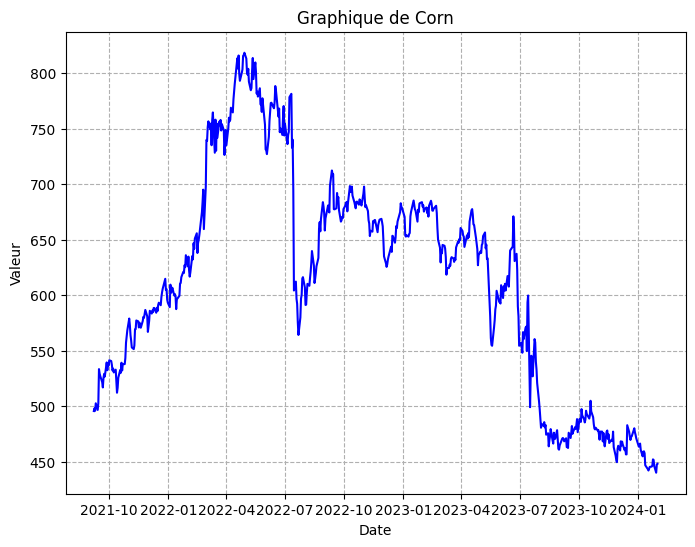

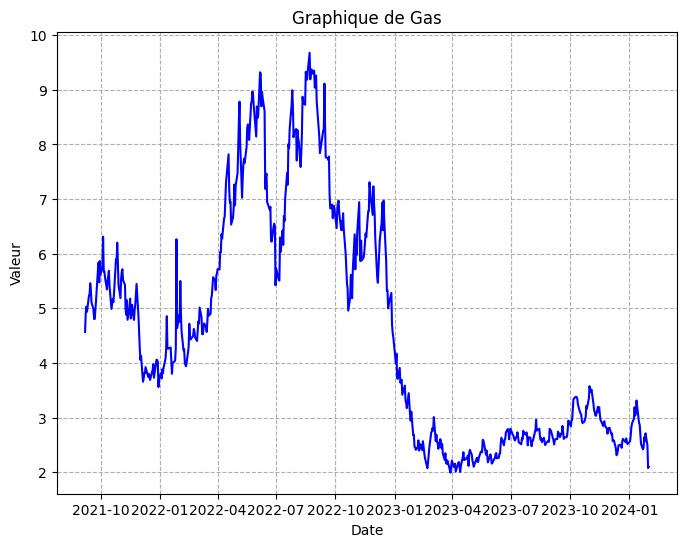

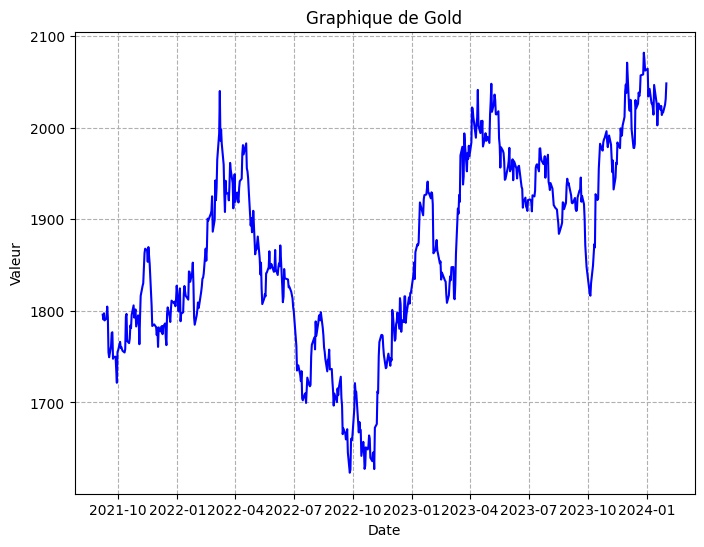

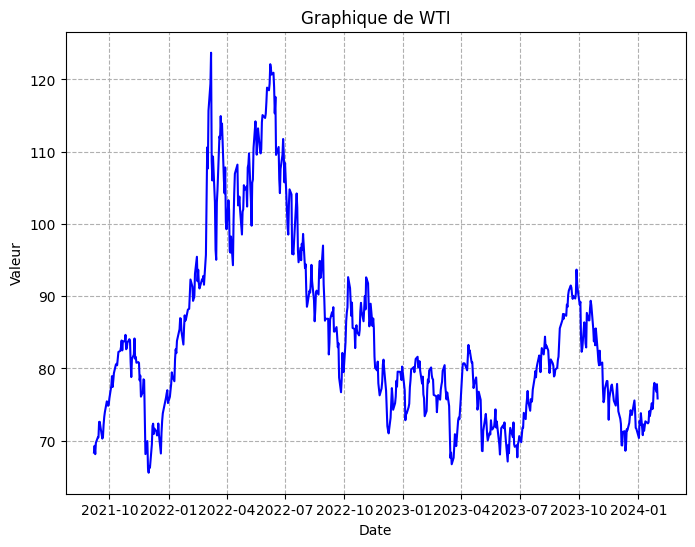

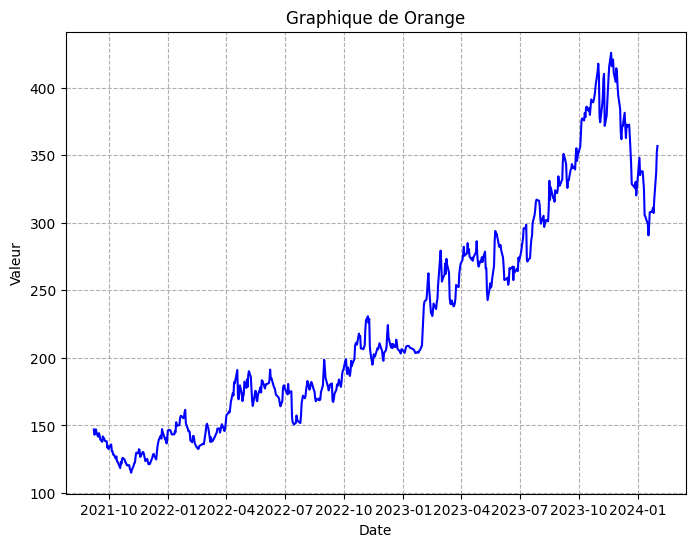

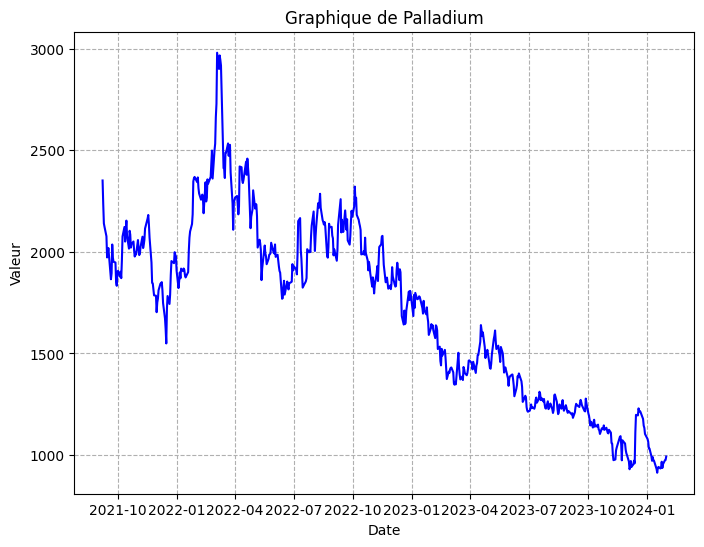

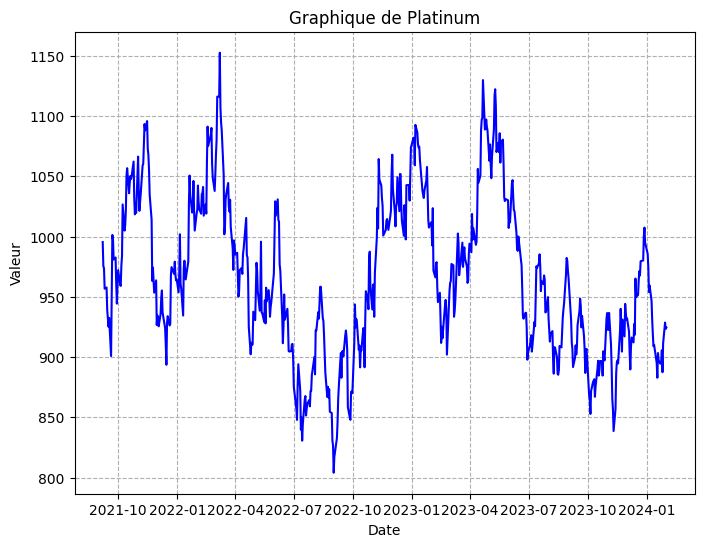

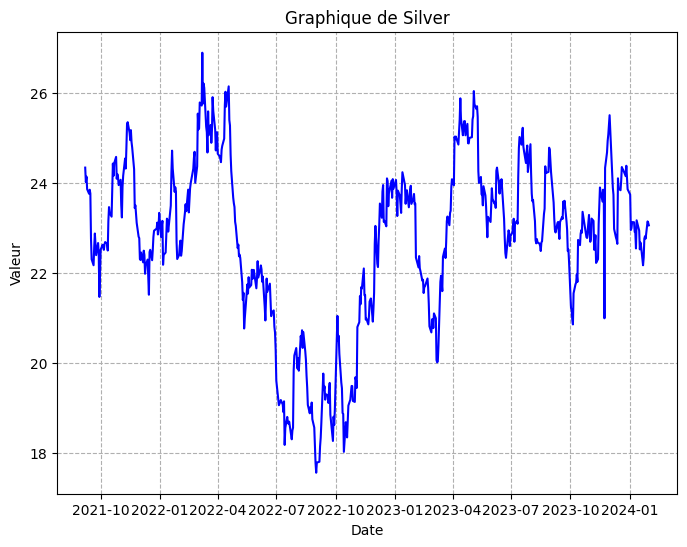

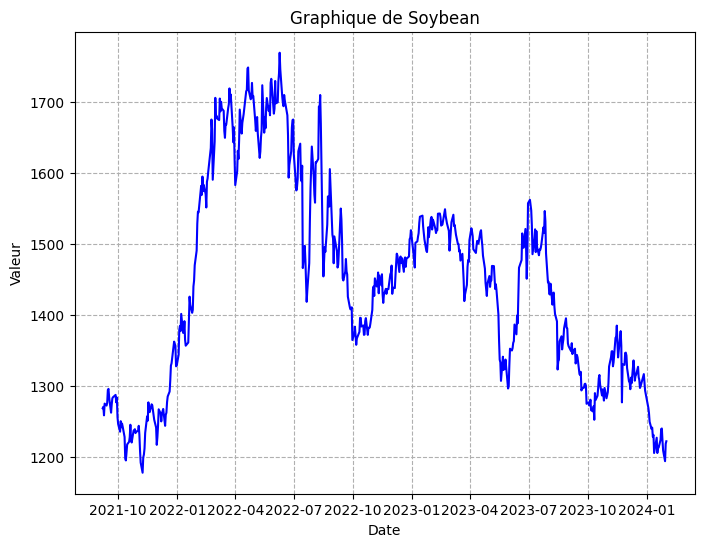

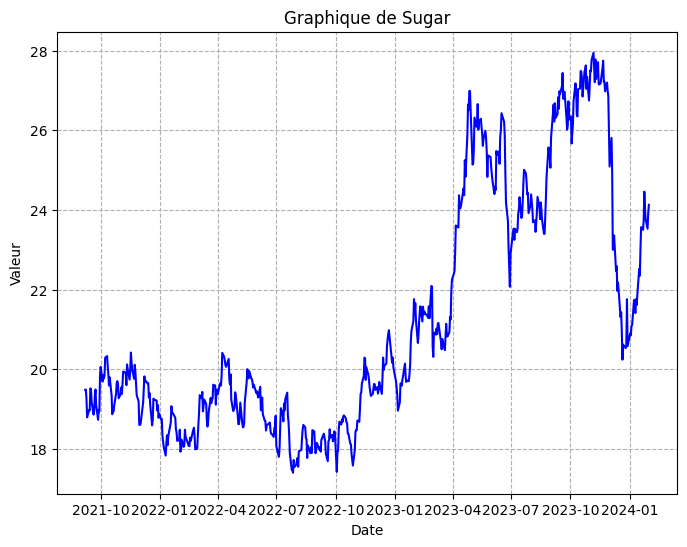

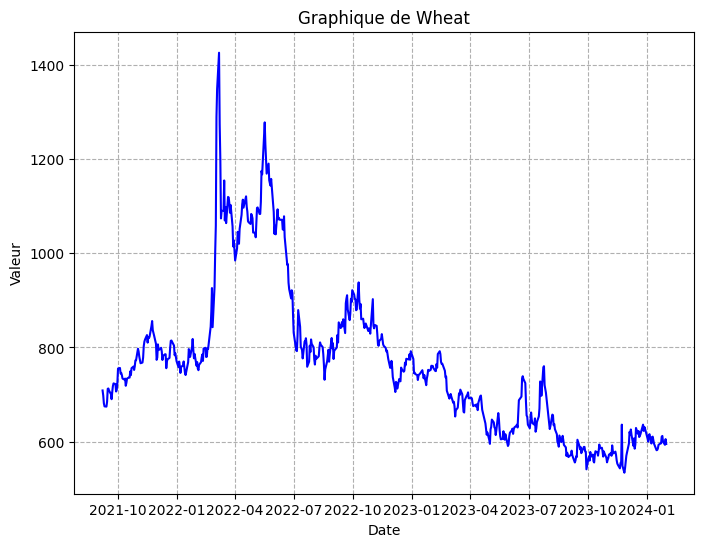

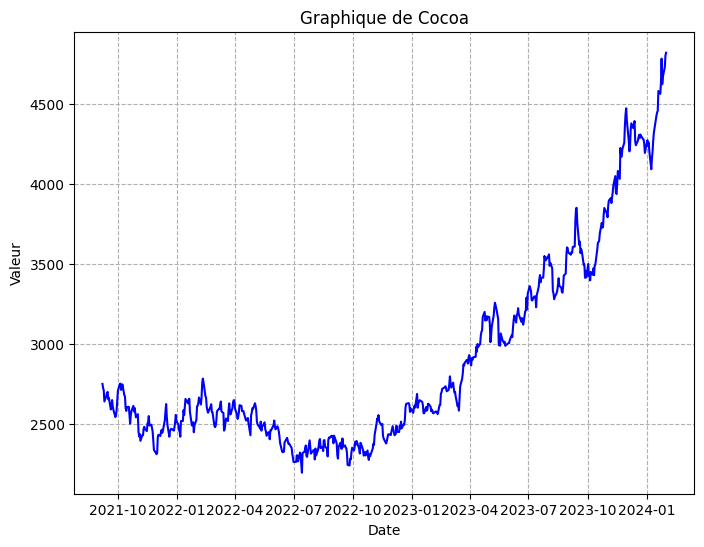

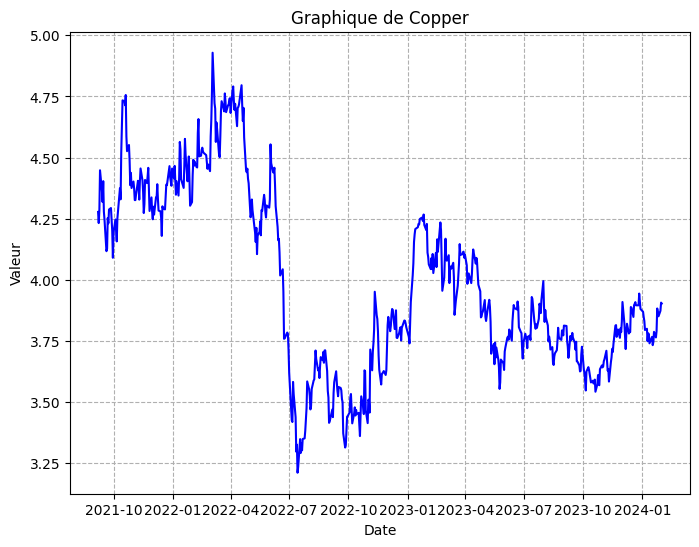

In [8]:
# Analyse graphique de chaque variable

for column in data.columns:
    plt.figure(figsize=(8, 6))  
    plt.plot(data.index, data[column], color = 'blue')  
    plt.title(f"Graphique de {column}")  
    plt.xlabel("Date")  # Libellé de l'axe des x
    plt.ylabel("Valeur")  # Libellé de l'axe des y
    plt.grid(True, linestyle ='--')  
    plt.show()  

In [9]:
# Centrage et réduction des données pour standardisation

scaler = StandardScaler()

x_train = scaler.fit_transform(data)

x_train = pd.DataFrame(x_train, columns=data.columns, index=data.index)

x_train.head()

Corn       Gas      Gold       WTI    Orange  Palladium  \
Date                                                                      
2021-09-07 -1.180318 -0.005856 -0.662809 -1.267959 -0.976236   1.436662   
2021-09-08 -1.155088  0.158862 -0.712072 -1.191898 -1.023875   1.173758   
2021-09-09 -1.177795  0.214562 -0.648599 -1.284773 -1.009827   0.956300   
2021-09-10 -1.109675  0.170288 -0.722493 -1.158272 -0.975015   0.918126   
2021-09-13 -1.170226  0.309774 -0.699756 -1.099826 -1.036090   0.812692   

            Platinum    Silver   Soybean     Sugar     Wheat     Cocoa  \
Date                                                                     
2021-09-07  0.444355  0.882677 -1.208245 -0.575406 -0.352694 -0.232280   
2021-09-08  0.137429  0.711407 -1.194386 -0.572103 -0.417942 -0.274913   
2021-09-09  0.114524  0.775766 -1.277539 -0.654655 -0.522029 -0.297869   
2021-09-10 -0.146591  0.627900 -1.163204 -0.803248 -0.562421 -0.412649   
2021-09-13 -0.131321  0.573647 -1.182260 -0.740509 -0.565528 -0.356898   

              Copper  
Date                  
2021-09-07  0.794883  
2021-09-08  0.672376  
2021-09-09  0.811038  
2021-09-10  1.253944  
2021-09-13  1.026433

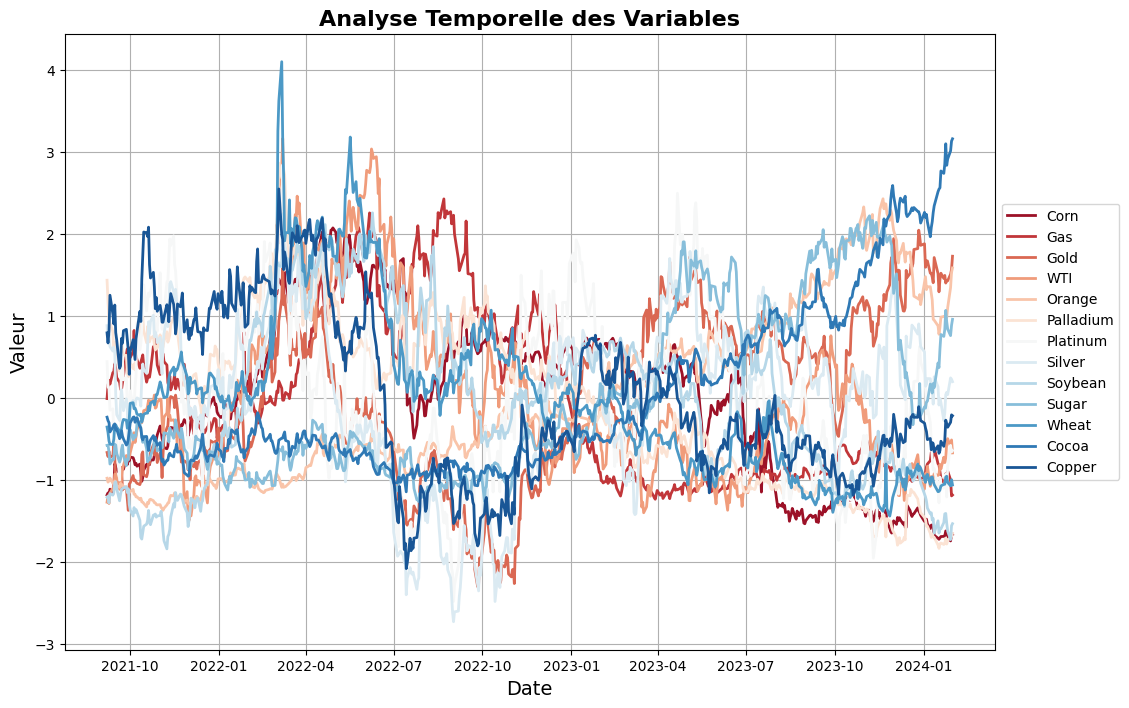

In [10]:
# Analyse temporelle des variables 

palette = sns.color_palette("RdBu", n_colors=len(x_train.columns)) 

plt.figure(figsize=(12, 8))

for idx, column in enumerate(x_train.columns):
    plt.plot(x_train.index, x_train[column],
             label=column, color=palette[idx], linewidth=2)

plt.title('Analyse Temporelle des Variables', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Valeur', fontsize=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

<Figure size 1400x800 with 0 Axes>

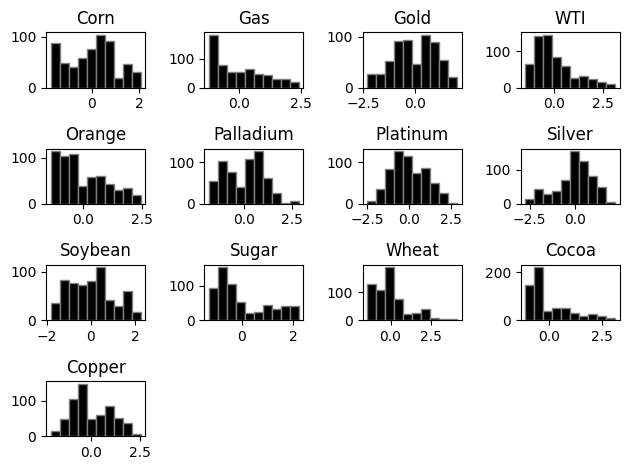

In [11]:
# Distribution des observations

x = [col for col in x_train.columns if col != 'Date']

# Créer un histogramme pour chaque colonne
plt.figure(figsize=(14, 8))
x_train[x].hist(bins=10, color='black', 
             edgecolor='grey',
                    grid=False)
plt.tight_layout()
plt.show()

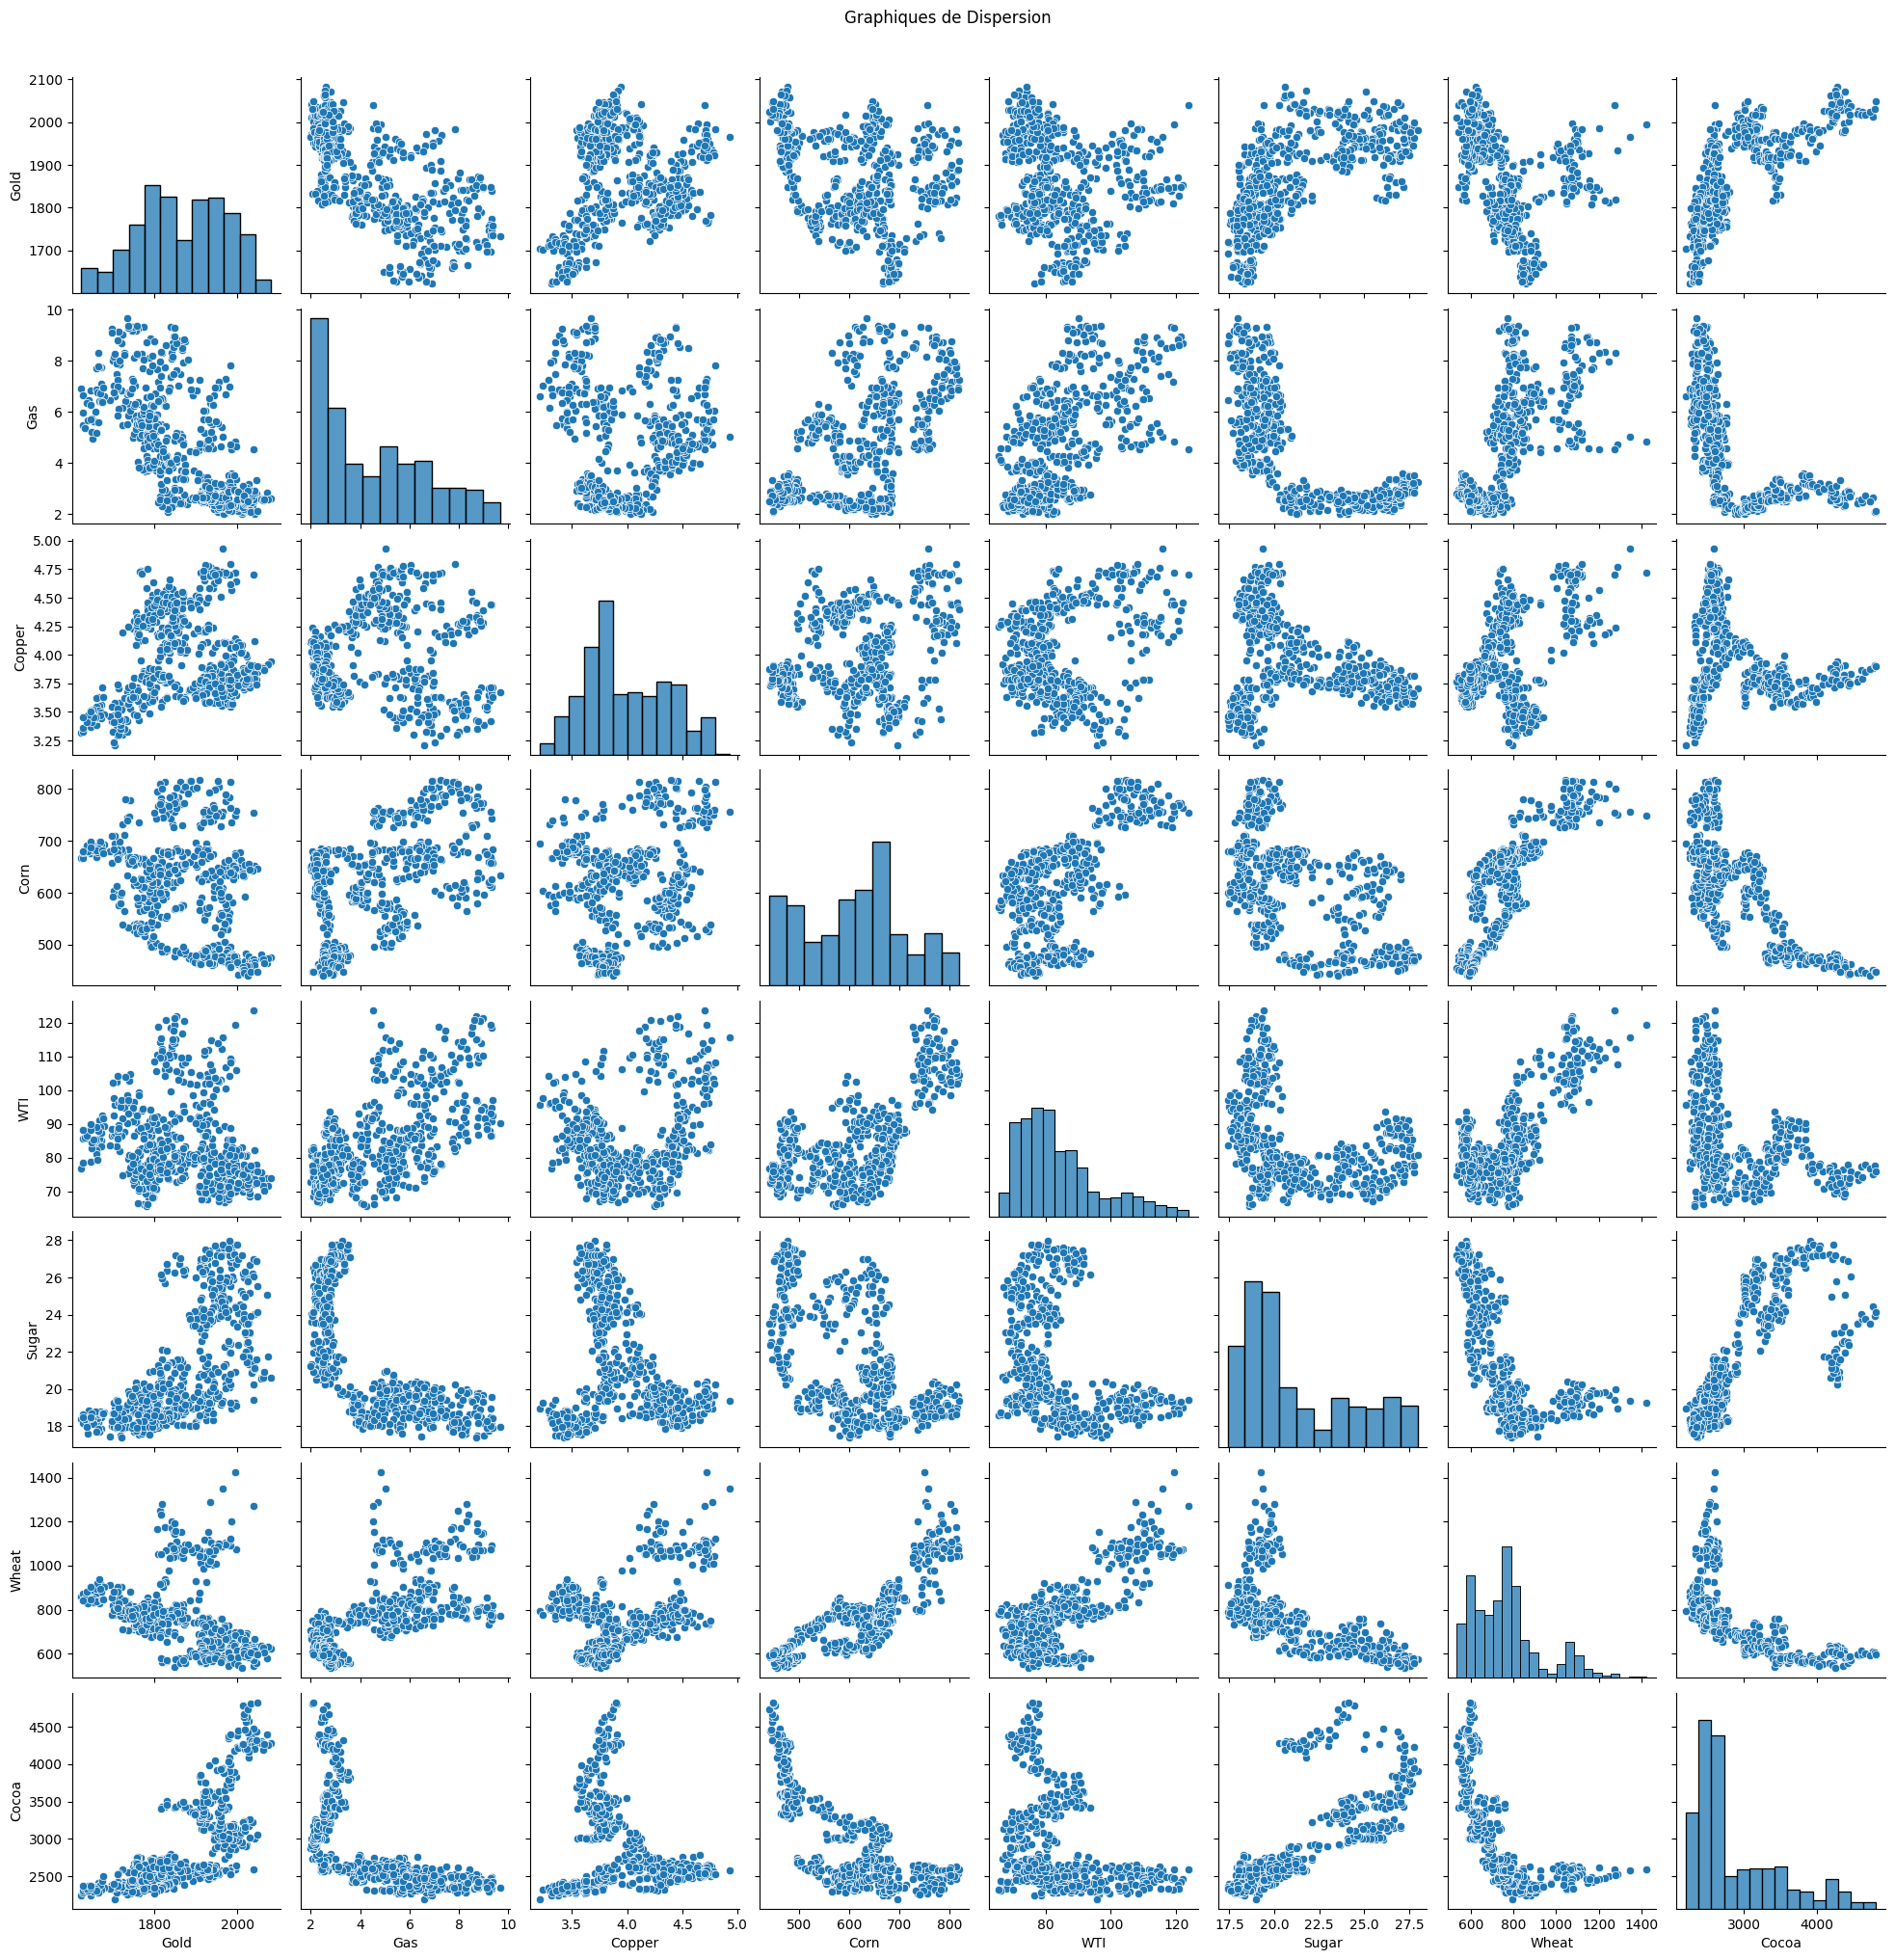

In [12]:
# Permet d'étudier via les graphiques dispersions les relations de non-linéarité entre les variables

corr_matrix = data.corr()
variables = ['Gold',  # On peut changer les variables pour décider de notre analyse spécifique
                 'Gas',
                        'Copper', 
                                 'Corn', 
                                         'WTI',
                                 'Sugar', 
                         'Wheat', 
            'Cocoa' ]

sns.pairplot(data[variables])
plt.suptitle('Graphiques de Dispersion', y=1.02) 
plt.show()

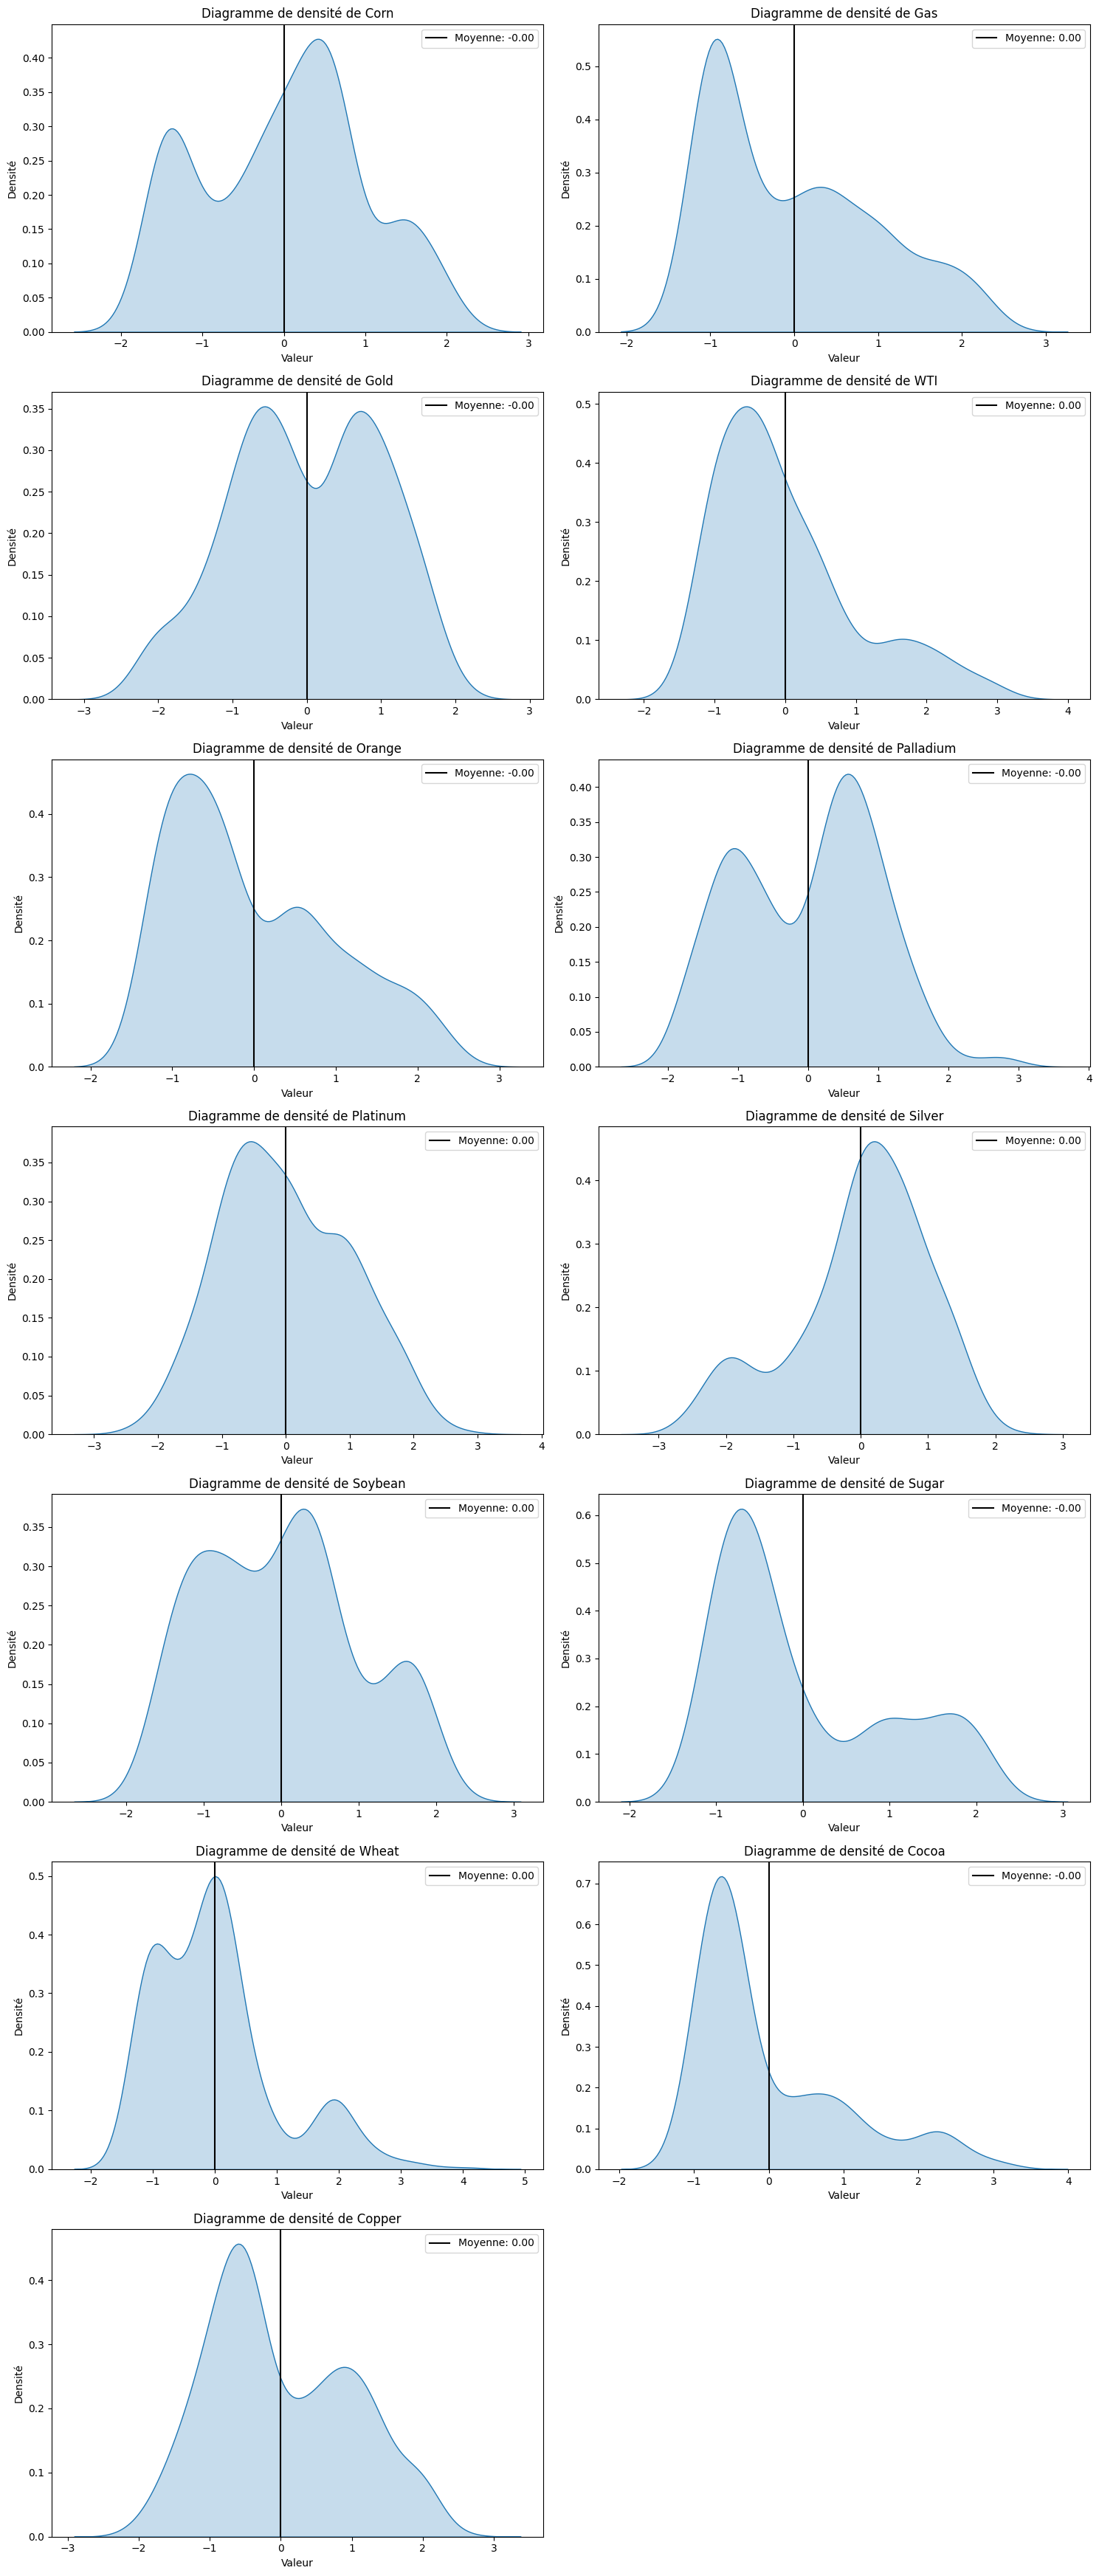

In [13]:
# Création de Diagramme de densité 

num_variables = len(x_train.columns)
num_rows = (num_variables + 1) // 2  # Nombre de lignes
num_cols = 2  # Nombre de colonnes

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

for i, column in enumerate(x_train.columns):
    row = i // num_cols
    col = i % num_cols
    
    # Créer le diagramme de densité sur le sous-graphique correspondant
    sns.kdeplot(x_train[column], shade=True, ax=axs[row, col])
    
    # Moyenne
    mean_value = x_train[column].mean()
    axs[row, col].axvline(mean_value, color='black', linestyle='-', label=f'Moyenne: {mean_value:.2f}')
    axs[row, col].legend()
    axs[row, col].set_xlabel('Valeur')
    axs[row, col].set_ylabel('Densité')
    axs[row, col].set_title(f'Diagramme de densité de {column}')

# Masquer les sous-graphiques vides s'il y en a
for i in range(num_variables, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()
'''Les diagrammes de densité servent à visualiser la distribution des données dans les séries temporelles, 
offrant un aperçu de la variabilité, des tendances centrales, et des anomalies au fil du temps. 
Ils sont utiles pour identifier les comportements comme la saisonnalité, les pics ou les distributions 
atypiques dans les données.'''

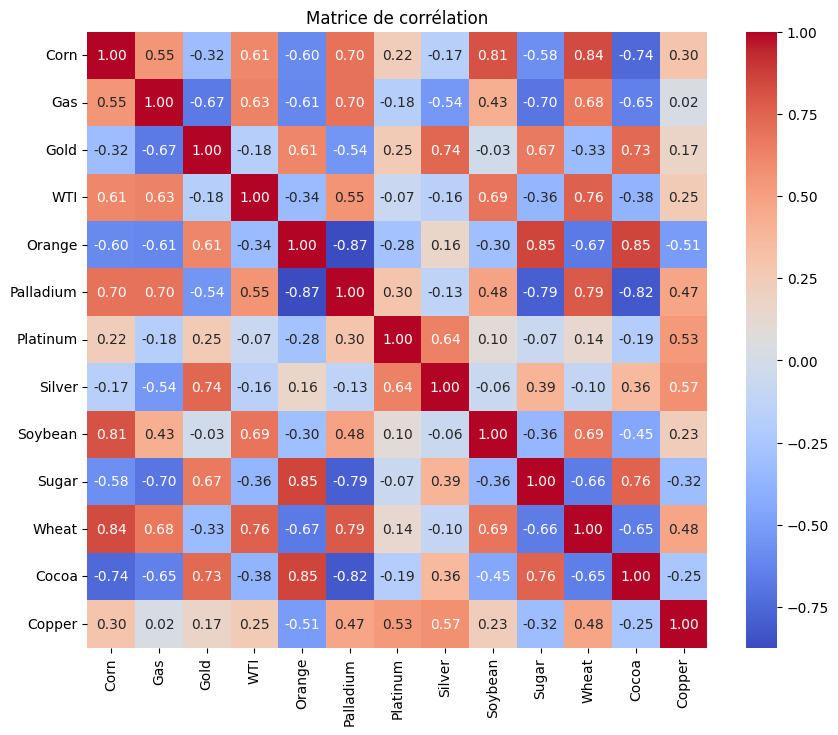

In [14]:
# Création de la heatmap matrice de corrélations 

correlation_matrix = x_train[['Corn', 
                                'Gas', 
                                    'Gold',
                                        'WTI',
                           'Orange',
                                    'Palladium',
                        'Platinum',
               'Silver',
    'Soybean',
                'Sugar',
                         'Wheat', 
                                  'Cocoa',
                'Copper']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation')
plt.show()

In [15]:
# Statistique descriptives

b = ['Corn', 'Gas', 'Gold', 'WTI', 'Orange', 'Palladium', 'Platinum']
c = ['Silver', 'Soybean', 'Sugar', 'Wheat', 'Cocoa', 'Copper']

# En 2 tableaux afin que cela soit lisible
descriptive_stats_1 = data[b].describe(include='all')
descriptive_stats_2 = data[c].describe(include='all')

print("Statistiques descriptives pour les 7 premières variables :")
print(descriptive_stats_1.to_string())

print("\nStatistiques descriptives pour les 6 variables restantes :")
print(descriptive_stats_2.to_string())

Statistiques descriptives pour les 7 premières variables :
             Corn         Gas         Gold         WTI      Orange    Palladium     Platinum
count  605.000000  605.000000   605.000000  605.000000  605.000000   605.000000   605.000000
mean   612.707438    4.580301  1865.864460   84.186893  226.921074  1718.946775   966.299998
std     99.171773    2.102298   105.644772   12.500401   81.934283   440.448994    65.542375
min    440.250000    1.991000  1623.300049   65.570000  115.000000   913.200012   804.000000
25%    530.500000    2.641000  1788.500000   75.190002  157.350006  1291.800049   917.500000
50%    625.500000    4.056000  1862.900024   80.820000  205.649994  1815.199951   960.200012
75%    677.500000    6.200000  1953.800049   89.879997  282.200012  2038.400024  1018.700012
max    818.250000    9.680000  2081.899902  123.699997  425.799988  2979.899902  1152.500000

Statistiques descriptives pour les 6 variables restantes :
           Silver      Soybean       Sugar  

In [16]:
# On a donc désormais 2 dataframes

# 1er dataframe
data.head()    #Plus adapté aux série temporelles si besoin par la suite

Corn    Gas         Gold        WTI      Orange    Palladium  \
Date                                                                         
2021-09-07  495.75  4.568  1795.900024  68.349998  147.000000  2351.199951   
2021-09-08  498.25  4.914  1790.699951  69.300003  143.100006  2235.500000   
2021-09-09  496.00  5.031  1797.400024  68.139999  144.250000  2139.800049   
2021-09-10  502.75  4.938  1789.599976  69.720001  147.100006  2123.000000   
2021-09-13  496.75  5.231  1792.000000  70.449997  142.100006  2076.600098   

              Platinum     Silver  Soybean      Sugar   Wheat  Cocoa  Copper  
Date                                                                          
2021-09-07  995.400024  24.334000  1268.75  19.480000  708.75   2753  4.2775  
2021-09-08  975.299988  24.011999  1270.75  19.490000  698.25   2727  4.2320  
2021-09-09  973.799988  24.132999  1258.75  19.240000  681.50   2713  4.2835  
2021-09-10  956.700012  23.855000  1275.25  18.790001  675.00   2643  4.4480  
2021-09-13  957.700012  23.753000  1272.50  18.980000  674.50   2677  4.3635

In [17]:
# 2ème dataframe
x_train.head()  #Centrée - réduit (indispensable pour les tâches de ML)

Corn       Gas      Gold       WTI    Orange  Palladium  \
Date                                                                      
2021-09-07 -1.180318 -0.005856 -0.662809 -1.267959 -0.976236   1.436662   
2021-09-08 -1.155088  0.158862 -0.712072 -1.191898 -1.023875   1.173758   
2021-09-09 -1.177795  0.214562 -0.648599 -1.284773 -1.009827   0.956300   
2021-09-10 -1.109675  0.170288 -0.722493 -1.158272 -0.975015   0.918126   
2021-09-13 -1.170226  0.309774 -0.699756 -1.099826 -1.036090   0.812692   

            Platinum    Silver   Soybean     Sugar     Wheat     Cocoa  \
Date                                                                     
2021-09-07  0.444355  0.882677 -1.208245 -0.575406 -0.352694 -0.232280   
2021-09-08  0.137429  0.711407 -1.194386 -0.572103 -0.417942 -0.274913   
2021-09-09  0.114524  0.775766 -1.277539 -0.654655 -0.522029 -0.297869   
2021-09-10 -0.146591  0.627900 -1.163204 -0.803248 -0.562421 -0.412649   
2021-09-13 -0.131321  0.573647 -1.182260 -0.740509 -0.565528 -0.356898   

              Copper  
Date                  
2021-09-07  0.794883  
2021-09-08  0.672376  
2021-09-09  0.811038  
2021-09-10  1.253944  
2021-09-13  1.026433

In [18]:
# On exporte les data pour aller plus vite sur la partie ML

output_file = 'data_forML.xlsx'
x_train.to_excel(output_file, index=True)

# <u>II - Stationnarité</u>

In [19]:
# Test ADF
variables = ['Corn', 
                    'Gas', 
                            'Gold',
                                    'WTI',
                                               'Orange',
                                    'Palladium',
                        'Platinum',
               'Silver',
    'Soybean',
                'Sugar',
                         'Wheat', 
                                  'Cocoa',
                'Copper']

def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    print('Test de Dickey-Fuller pour', series.name)
    print('Statistique de test :', result[0])
    print('P-valeur :', result[1])
    print('Valeurs critiques :')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    print('Conclusion :')
    if result[1] <= 0.05:
        print('La série est stationnaire au niveau de signification de 5%.')
    else:
        print('La série n\'est pas stationnaire au niveau de signification de 5%.')

for variable in variables:
    adf_test(x_train[variable])

Test de Dickey-Fuller pour Corn
Statistique de test : -0.8635760684157849
P-valeur : 0.7997306410011198
Valeurs critiques :
   1%: -3.4413325959192393
   5%: -2.86638530474078
   10%: -2.569350430308386
Conclusion :
La série n'est pas stationnaire au niveau de signification de 5%.
Test de Dickey-Fuller pour Gas
Statistique de test : -1.2230039669432122
P-valeur : 0.663622539356843
Valeurs critiques :
   1%: -3.441241137539733
   5%: -2.8663450276569797
   10%: -2.569328969112426
Conclusion :
La série n'est pas stationnaire au niveau de signification de 5%.
Test de Dickey-Fuller pour Gold
Statistique de test : -1.6575462225486233
P-valeur : 0.4531078790877973
Valeurs critiques :
   1%: -3.4413510722333087
   5%: -2.8663934413235266
   10%: -2.5693547658168003
Conclusion :
La série n'est pas stationnaire au niveau de signification de 5%.
Test de Dickey-Fuller pour WTI
Statistique de test : -1.8828049584876865
P-valeur : 0.3401929313895298
Valeurs critiques :
   1%: -3.4413325959192393
  

# <u>III - Cointégration</u>

In [20]:
# Test Johansen

data_for_test = data[['Corn', 'Copper']] # Sélection des variables pour le test de cointégration
johansen_test = coint_johansen(data_for_test, det_order=0, k_ar_diff=1)
trace_stats = johansen_test.lr1  
trace_crit_vals = johansen_test.cvt  # Valeurs critiques (90%, 95%, 99%)

print("Statistiques de trace:", trace_stats)
print("Valeurs critiques (90%, 95%, 99%):", trace_crit_vals)

# Interprétation des résultats
n = len(data_for_test.columns)
for i in range(n):
    if trace_stats[i] > trace_crit_vals[i, 1]:  # 0 pour 90%, 1 pour 95%, 2 pour 99%
        print(f"Preuve de cointégration pour au moins {i+1} relation(s)")
    else:
        print(f"Pas de preuve suffisante pour cointégration pour {i+1} relation(s)")
        break  # Arrêter l'interprétation dès qu'il n'y a pas de preuve de cointégration supplémentaire

Statistiques de trace: [18.65000113  4.36375144]
Valeurs critiques (90%, 95%, 99%): [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Preuve de cointégration pour au moins 1 relation(s)
Preuve de cointégration pour au moins 2 relation(s)


In [21]:
# Création d'une fonction qui va permettre d'afficher seulement toutes les relations de cointégration

def test_cointegration_pairs(data):
    """
    Teste la cointégration pour toutes les paires possibles de variables dans un DataFrame et
    affiche uniquement les paires cointégrées.
    
    :param data: DataFrame Pandas avec les séries temporelles.
    """
    
    pairs = combinations(data.columns, 2)
    
    # Parcourir chaque paire et effectuer le test de cointégration
    for pair in pairs:
        subset = data[list(pair)]
        
        # Applique le test
        result = coint_johansen(subset, det_order=0, k_ar_diff=1)
        
        # Extraire la statistique de trace et les valeurs critiques à 95%
        trace_stat = result.lr1[0]  # Prendre la première valeur de statistique de trace
        crit_value = result.cvt[0, 1]  # Prendre la valeur critique à 95% pour r=0
        
        # Règle de décision
        if trace_stat > crit_value:
            print(f"Pair testée: {pair}")
            print(f"Statistique de trace: {trace_stat}, Valeur critique à 95%: {crit_value}")
            print("Résultat: Preuve de cointégration\n")
test_cointegration_pairs(data)

Pair testée: ('Corn', 'Palladium')
Statistique de trace: 17.697425155330052, Valeur critique à 95%: 15.4943
Résultat: Preuve de cointégration

Pair testée: ('Corn', 'Platinum')
Statistique de trace: 16.80378275573722, Valeur critique à 95%: 15.4943
Résultat: Preuve de cointégration

Pair testée: ('Corn', 'Copper')
Statistique de trace: 18.65000113387253, Valeur critique à 95%: 15.4943
Résultat: Preuve de cointégration

Pair testée: ('Gold', 'Platinum')
Statistique de trace: 19.47032855415154, Valeur critique à 95%: 15.4943
Résultat: Preuve de cointégration

Pair testée: ('WTI', 'Platinum')
Statistique de trace: 19.26691184123944, Valeur critique à 95%: 15.4943
Résultat: Preuve de cointégration

Pair testée: ('WTI', 'Silver')
Statistique de trace: 17.01395689830626, Valeur critique à 95%: 15.4943
Résultat: Preuve de cointégration

Pair testée: ('WTI', 'Wheat')
Statistique de trace: 17.391088282196247, Valeur critique à 95%: 15.4943
Résultat: Preuve de cointégration

Pair testée: ('WTI',

# <u>IV - Machine Learning</u>

In [22]:
# Pour cette partie on travail exclusivement avec x_train

x_train.head()

Corn       Gas      Gold       WTI    Orange  Palladium  \
Date                                                                      
2021-09-07 -1.180318 -0.005856 -0.662809 -1.267959 -0.976236   1.436662   
2021-09-08 -1.155088  0.158862 -0.712072 -1.191898 -1.023875   1.173758   
2021-09-09 -1.177795  0.214562 -0.648599 -1.284773 -1.009827   0.956300   
2021-09-10 -1.109675  0.170288 -0.722493 -1.158272 -0.975015   0.918126   
2021-09-13 -1.170226  0.309774 -0.699756 -1.099826 -1.036090   0.812692   

            Platinum    Silver   Soybean     Sugar     Wheat     Cocoa  \
Date                                                                     
2021-09-07  0.444355  0.882677 -1.208245 -0.575406 -0.352694 -0.232280   
2021-09-08  0.137429  0.711407 -1.194386 -0.572103 -0.417942 -0.274913   
2021-09-09  0.114524  0.775766 -1.277539 -0.654655 -0.522029 -0.297869   
2021-09-10 -0.146591  0.627900 -1.163204 -0.803248 -0.562421 -0.412649   
2021-09-13 -0.131321  0.573647 -1.182260 -0.740509 -0.565528 -0.356898   

              Copper  
Date                  
2021-09-07  0.794883  
2021-09-08  0.672376  
2021-09-09  0.811038  
2021-09-10  1.253944  
2021-09-13  1.026433

# <u>A - Lasso</u>

In [1]:
# Lasso 

X = data.drop(['Gold'], axis=1)
y = data['Gold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Entraîner le modèle LASSO
lasso = Lasso(alpha=0.31257158496882353)  # On peut ajuster l'alpha comme on le veut 
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)

# Affiche les coefficients du modèle
coefficients = pd.Series(lasso.coef_, index=X_train.columns)
print("Coefficients du modèle LASSO:")
print(coefficients.sort_values())

NameError: name 'data' is not defined

In [24]:
#Cross validation
lasso_cv = LassoCV(alphas=np.logspace(-10, 10, 100), cv=5, random_state=99, max_iter=50000)
lasso_cv.fit(X_train, y_train)
y_pred_cv = lasso_cv.predict(X_test)
mse_cv = mean_squared_error(y_test, y_pred_cv)

# Obtenir l'alpha optimal
alpha_optimal = lasso_cv.alpha_
print(f"L'alpha optimal trouvé par validation croisée est : {alpha_optimal}")

L'alpha optimal trouvé par validation croisée est : 0.31257158496882353


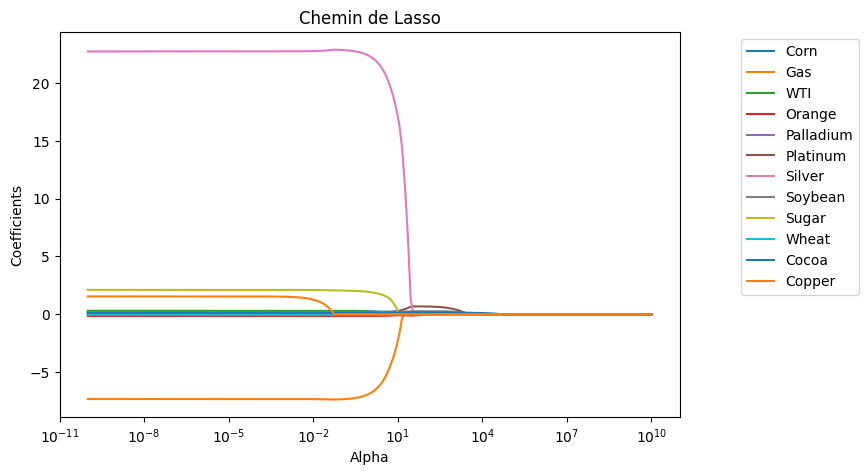

In [25]:
alphas = np.logspace(-10, 10, 200)

coef_paths = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000)
    lasso.fit(X_train, y_train)
    coef_paths.append(lasso.coef_)

coef_paths = np.array(coef_paths)

# Chemin de Lasso
plt.figure(figsize=(8, 5))
for i in range(coef_paths.shape[1]):
    plt.plot(alphas, coef_paths[:, i], label=X_train.columns[i])

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Chemin de Lasso')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
plt.axis('tight')
plt.show()

In [50]:
#Forecast made by Lasso

selected_features = ['Silver', 'Platinum', 'Palladium', 'Gas']
X = data[selected_features]  # Variables explicatives selected by Lasso & interprétation économique
y = data['Gold']  # Variable cible

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ols_model = LinearRegression()
ols_model.fit(X_train, y_train)
y_pred = ols_model.predict(X_test)

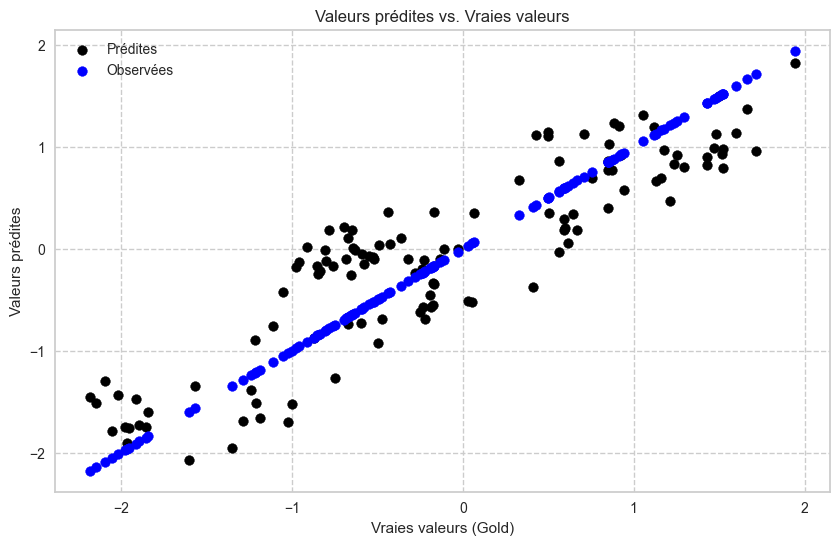

In [51]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='black', label='Prédites')
plt.scatter(y_test, y_test, color='blue', label='Observées')
plt.xlabel('Vraies valeurs (Gold)')
plt.ylabel('Valeurs prédites')
plt.title('Valeurs prédites vs. Vraies valeurs')
plt.legend()
plt.grid(True, linestyle ='--')
plt.show()

# <u>B - Long Short-Term Memory (LSTM)</u>

In [28]:
# Séquencement des données

data_forML = pd.read_excel('data_forML.xlsx')

# Sélectionner les variables prédictives et la variable cible
X = data_forML[['Silver', 'Platinum', 'Palladium', 'Gas', 'Cocoa']]  # Variables prédictives
y = data_forML['Gold']  # Variable cible

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Entraînement du modèle
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.0287 - val_loss: 1.0184
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8759 - val_loss: 0.8352
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5599 - val_loss: 0.5554
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4076 - val_loss: 0.3215
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2553 - val_loss: 0.2684
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2301 - val_loss: 0.2434
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2306 - val_loss: 0.2255
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1975 - val_loss: 0.2089
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1884 - val_loss: 0.1996
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1679 - val_loss: 0.1908
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1611 - val_loss: 0.1805
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step
Train MSE: 0.05229599424037672
Test MSE: 0.05441854781314577


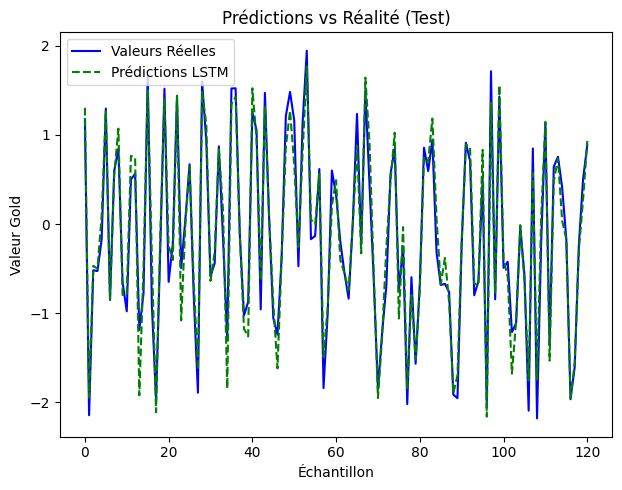

In [29]:
# Forecasting
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculer l'erreur quadratique moyenne (MSE)
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, 2e subplot
plt.plot(y_test.to_numpy(), label='Valeurs Réelles', color='blue')
plt.plot(y_pred_test, label='Prédictions LSTM', color='green', linestyle='--')
plt.title('Prédictions vs Réalité (Test)')
plt.xlabel('Échantillon')
plt.ylabel('Valeur Gold')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step


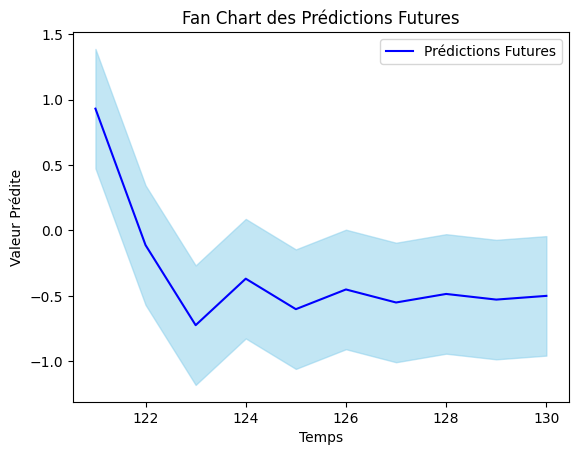

In [30]:
# Forecasting on new data
last_sequence = X_test[-1]
last_sequence = last_sequence.reshape((1, last_sequence.shape[0], last_sequence.shape[1]))
future_predictions = []
for _ in range(10):
    # Faire une prédiction avec le modèle
    next_prediction = model.predict(last_sequence)
    # Ajouter la prédiction à la liste des prédictions futures
    future_predictions.append(next_prediction[0][0])
    # Mettre à jour la dernière séquence avec la nouvelle prédiction
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[0, -1, :] = next_prediction
    
y_pred_test = model.predict(X_test)  
errors = y_pred_test.flatten() - y_test.values
std_dev_error = np.std(errors)
uncertainty = std_dev_error * 1.96  # Pour un intervalle de confiance de 95%
upper_bound = np.array(future_predictions) + uncertainty
lower_bound = np.array(future_predictions) - uncertainty

time_steps = np.arange(len(y_test), len(y_test) + 10)

# Créer le fan chart
plt.fill_between(time_steps, lower_bound, upper_bound, color='skyblue', alpha=0.5)
plt.plot(time_steps, future_predictions, color='blue', label='Prédictions Futures')
plt.title('Fan Chart des Prédictions Futures')
plt.xlabel('Temps')
plt.ylabel('Valeur Prédite')
plt.legend()
plt.show()

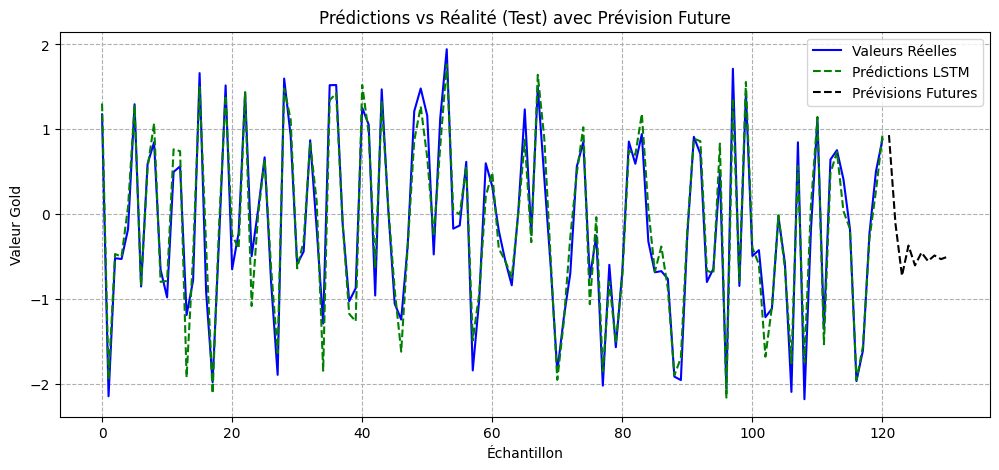

In [31]:
plt.figure(figsize=(12, 5))

# Afficher les valeurs réelles et les prédictions pour l'ensemble de test
plt.plot(y_test.to_numpy(), label='Valeurs Réelles', color='blue')
plt.plot(y_pred_test, label='Prédictions LSTM', color='green', linestyle='--')

# Afficher les prédictions futures
# Ces données seront ajoutées à la fin de la série y_test
plt.plot(range(len(y_test), len(y_test) + 10), future_predictions, label='Prévisions Futures', color='black', linestyle='--')

plt.title('Prédictions vs Réalité (Test) avec Prévision Future')
plt.xlabel('Échantillon')
plt.ylabel('Valeur Gold')
plt.legend()
plt.grid(True, linestyle ='--')
plt.show()

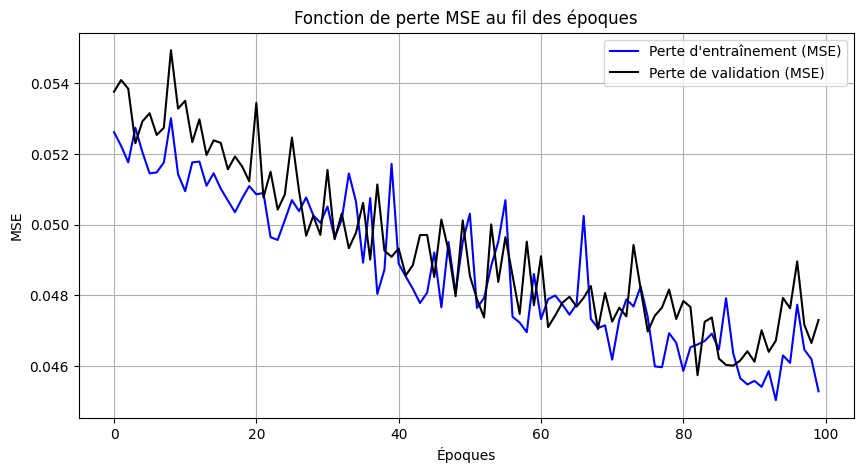

In [32]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_data=(X_test, y_test))

# Visualisation de la fonction de perte MSE
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Perte d\'entraînement (MSE)', color='blue')
plt.plot(history.history['val_loss'], label='Perte de validation (MSE)', color='black')

plt.title('Fonction de perte MSE au fil des époques')
plt.xlabel('Époques')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

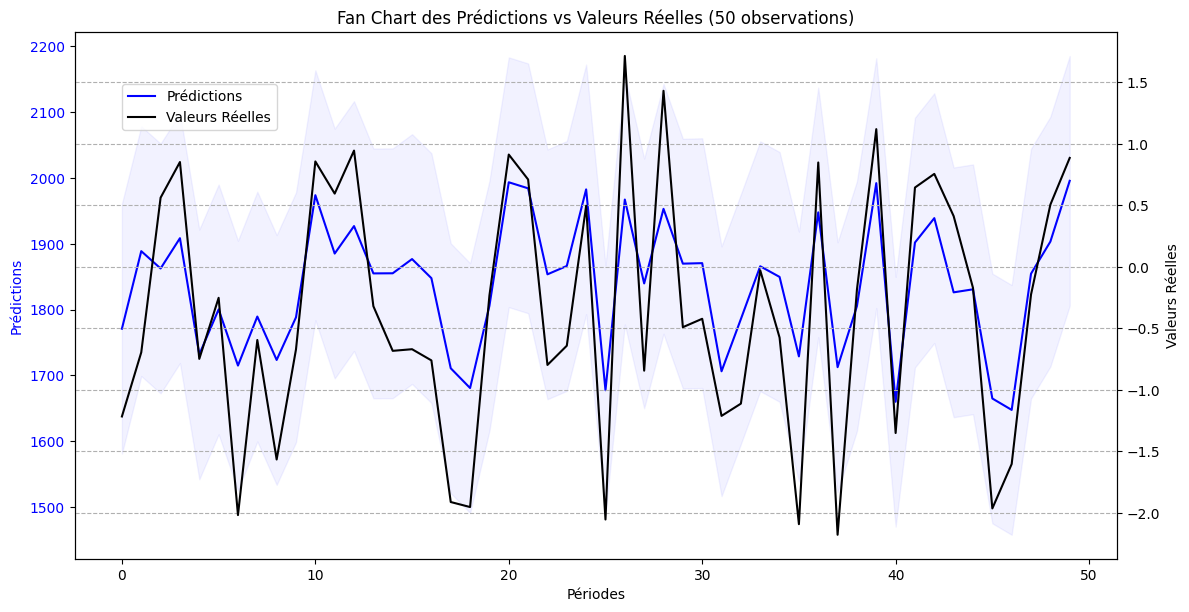

In [33]:
# Création d'un Fan Chart des Prédictions 

errors = y_pred.flatten() - y_test.values

errors_std = np.std(errors)
lower_bound = y_pred.flatten() - (errors_std * 1.96)
upper_bound = y_pred.flatten() + (errors_std * 1.96)

n = 50  # Nombre d'observations à afficher
y_pred_subset = y_pred.flatten()[-n:]
lower_bound_subset = lower_bound[-n:]
upper_bound_subset = upper_bound[-n:]
y_test_subset = y_test.values[-n:]

# On peut ajuster la taille de la figure
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.fill_between(range(n), lower_bound_subset, upper_bound_subset, color='blue', alpha=0.05)
ax1.plot(y_pred_subset, color='blue', label='Prédictions')
ax1.set_xlabel('Périodes')
ax1.set_ylabel('Prédictions', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Création d'un second axe pour les valeurs réelles
ax2 = ax1.twinx()  
ax2.plot(y_test_subset, color='black', label='Valeurs Réelles')
ax2.set_ylabel('Valeurs Réelles', color='black')  
ax2.tick_params(axis='y', labelcolor='black')

# Titre, légende, et grille
fig.tight_layout()  
plt.title('Fan Chart des Prédictions vs Valeurs Réelles (50 observations)')
fig.legend(loc="upper left", bbox_to_anchor=(0.10, 0.9))
plt.grid(True, linestyle ='--')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


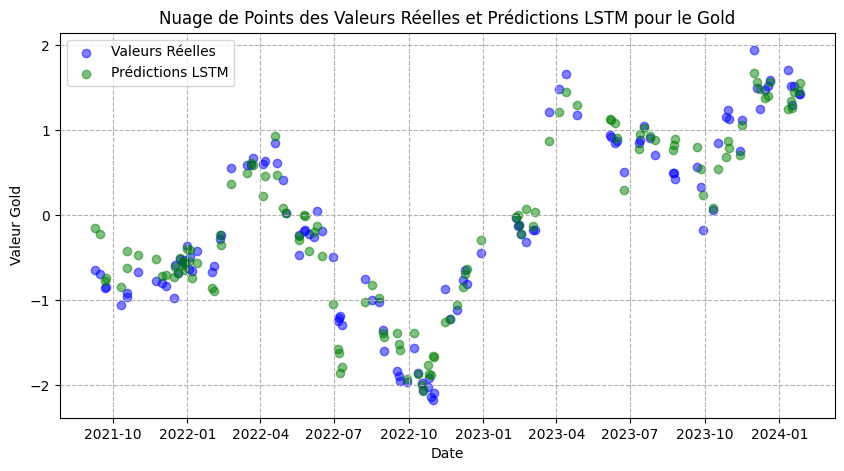

In [34]:
# Forecasting robust

data = pd.read_excel('data_forML.xlsx')
X = data[['Silver', 'Platinum', 'Palladium', 'Gas', 'Cocoa']]
y = data['Gold']
dates = pd.to_datetime(data['Date'])

# Division des données
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, dates, test_size=0.2, random_state=42)

# Remodelage pour le modèle LSTM
X_train = X_train.values.reshape((X_train.shape[0], 
                                     1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 
                1, X_test.shape[1]))

# LSTM
model = Sequential()
model.add(LSTM(units=50, activation='relu', 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
y_pred = model.predict(X_test)

# Visualisation
plt.figure(figsize=(10, 5))
plt.scatter(dates_test, y_test, color='blue', label='Valeurs Réelles', alpha=0.5)
plt.scatter(dates_test, y_pred, color='green', label='Prédictions LSTM', alpha=0.5)
plt.title('Nuage de Points des Valeurs Réelles et Prédictions LSTM pour le Gold')
plt.xlabel('Date')
plt.ylabel('Valeur Gold')
plt.legend()
plt.grid(True, linestyle ='--')
plt.show()

# <u>C - Gradient Boosting</u>

In [35]:
data['Date'] = pd.to_datetime(data['Date'])

# Extraire les caractéristiques de date pertinentes
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data.drop('Date', axis=1, inplace=True)

from sklearn.ensemble import GradientBoostingRegressor

X = data.drop('Gold', axis=1)
X = data[['Silver', 'Platinum', 'Palladium', 'Gas', 'Cocoa']] #Même variables issus du Lasso/Economics Selection
y = data['Gold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)

# Entraîner le modèle
gb_model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = gb_model.predict(X_test)

# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", np.sqrt(mse))

Mean Squared Error: 0.05566660803425065
Root Mean Squared Error: 0.23593772066850746


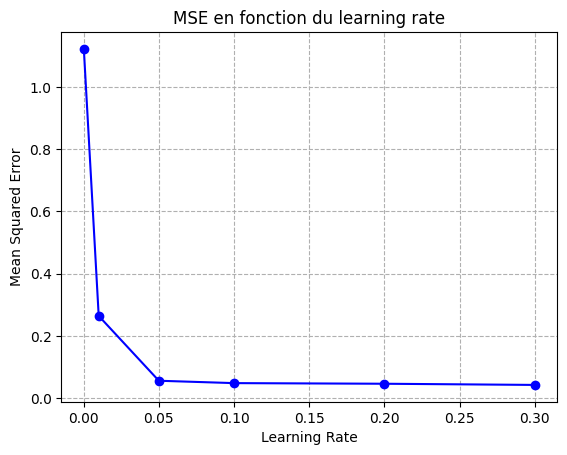

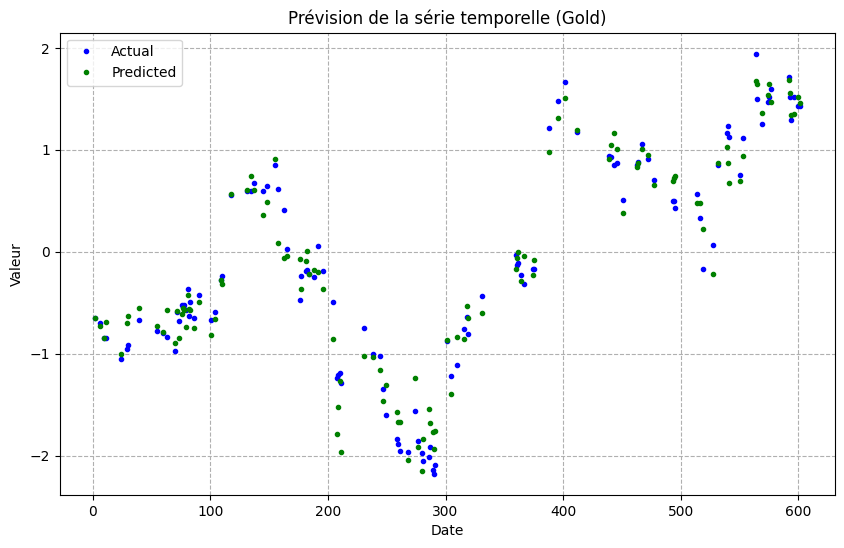

In [36]:
mse_values = []
learning_rates = [0.0001, 0.01, 0.05, 0.1, 0.2, 0.3]

# Boucle pour entraîner le modèle avec différents learning rates
for lr in learning_rates:
    # Initialiser le modèle Gradient Boosting
    gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=lr, max_depth=3, random_state=42)
    
    # Entraîner le modèle
    gb_model.fit(X_train, y_train)
    
    # Prédire sur l'ensemble de test
    y_pred = gb_model.predict(X_test)
    
    # Calculer MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_values.append(mse)

# Visualisation de la MSE en fonction du learning rate
plt.plot(learning_rates, mse_values, marker='o', color ='b')
plt.title('MSE en fonction du learning rate')
plt.xlabel('Learning Rate')
plt.ylabel('Mean Squared Error')
plt.grid(True, linestyle = '--')
plt.show()

# Prévision sous forme de dot plot
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, 'b.', label='Actual')
plt.plot(y_test.index, y_pred, 'g.', label='Predicted')
plt.title('Prévision de la série temporelle (Gold)')
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.grid(True, linestyle = '--')
plt.legend()
plt.show()

In [37]:
#RECAP PERFORMANCE ML

selected_features = ['Silver', 'Platinum', 'Palladium', 'Gas', 'Cocoa']
X_train_lstm = X_train[selected_features]
X_test_lstm = X_test[selected_features]

# 1. Modèle Lasso
lasso_model = Lasso(alpha=0.1) 
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("MSE Lasso:", mse_lasso)

# 2. Modèle LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm.values.reshape((X_train_lstm.shape[0], 
                                            X_train_lstm.shape[1], 1)), 
               y_train, epochs=50, batch_size=32)
y_pred_lstm = model_lstm.predict(X_test_lstm.values.reshape((X_test_lstm.shape[0], 
            X_test_lstm.shape[1], 1)))
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
print("MSE LSTM:", mse_lstm)

# 3. Modèle Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
            max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print("MSE Gradient Boosting:", mse_gb)

mse_results = {
    'Modèle': ['Lasso', 'LSTM', 'Gradient Boosting'],
    'MSE': [mse_lasso, mse_lstm, mse_gb]
}
df_results = pd.DataFrame(mse_results)

# Afficher le DataFrame
print(df_results)

MSE Lasso: 0.212313958755103
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9088
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.8665
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.8515
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.8341
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.8691
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 0.6084
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.3241
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.2627
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.2214
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.2100
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.2154
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 0.2025
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.1771
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1809 
Epoch 15/50
16/16 ━━━━━━━━━━━━━

In [38]:
# Récap all model 

import pandas as pd
from pycaret.regression import *

dataB = pd.read_excel('data_forML.xlsx')
dataB = dataB.drop(columns=['Date'])

# Selection des features
features_to_include = ['Silver', 'Platinum', 'Palladium', 'Gas', 'Cocoa', 'Gold']

data_selected = dataB[features_to_include]

exp_reg102 = setup(data=data_selected, target='Gold', session_id=123, verbose=False)
best_models_new = compare_models(sort='RMSE')

Processing:   0%|          | 0/77 [00:00<?, ?it/s]

# <u>V - Econometrics </u>

In [39]:
# On recharge les données utiles pour l'inférence statistique 

data = pd.read_excel('data_forML.xlsx')
data.head()

Date      Corn       Gas      Gold       WTI    Orange  Palladium  \
0 2021-09-07 -1.180318 -0.005856 -0.662809 -1.267959 -0.976236   1.436662   
1 2021-09-08 -1.155088  0.158862 -0.712072 -1.191898 -1.023875   1.173758   
2 2021-09-09 -1.177795  0.214562 -0.648599 -1.284773 -1.009827   0.956300   
3 2021-09-10 -1.109675  0.170288 -0.722493 -1.158272 -0.975015   0.918126   
4 2021-09-13 -1.170226  0.309774 -0.699756 -1.099826 -1.036090   0.812692   

   Platinum    Silver   Soybean     Sugar     Wheat     Cocoa    Copper  
0  0.444355  0.882677 -1.208245 -0.575406 -0.352694 -0.232280  0.794883  
1  0.137429  0.711407 -1.194386 -0.572103 -0.417942 -0.274913  0.672376  
2  0.114524  0.775766 -1.277539 -0.654655 -0.522029 -0.297869  0.811038  
3 -0.146591  0.627900 -1.163204 -0.803248 -0.562421 -0.412649  1.253944  
4 -0.131321  0.573647 -1.182260 -0.740509 -0.565528 -0.356898  1.026433

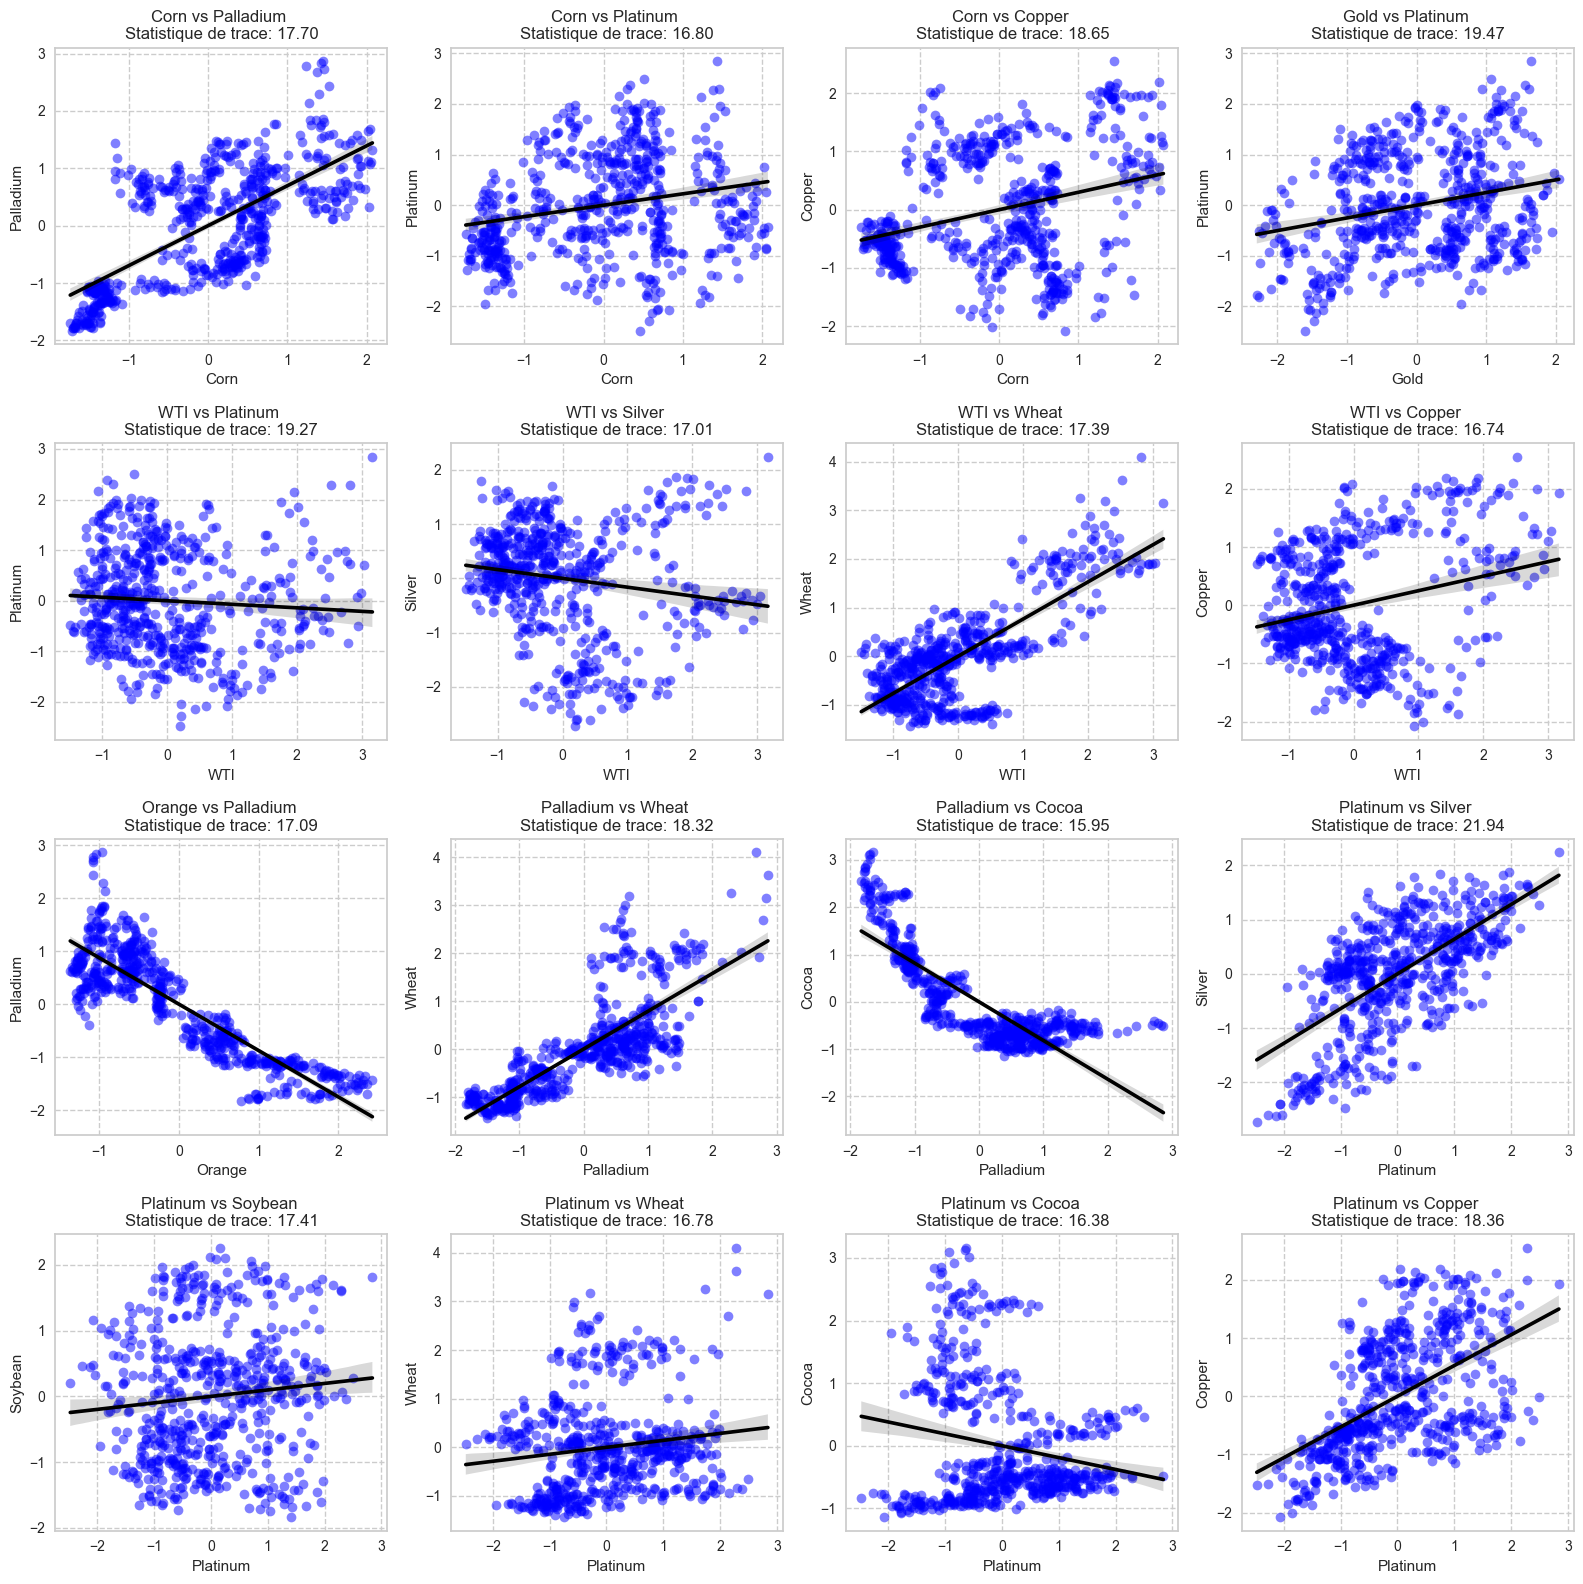

In [40]:
# Cointégration relation (testé précèdemment en début de projet)
pairs = [('Corn', 'Palladium'), ('Corn', 'Platinum'), ('Corn', 'Copper'), ('Gold', 'Platinum'),
         ('WTI', 'Platinum'), ('WTI', 'Silver'), ('WTI', 'Wheat'), ('WTI', 'Copper'),
         ('Orange', 'Palladium'), ('Palladium', 'Wheat'), ('Palladium', 'Cocoa'), 
         ('Platinum', 'Silver'), ('Platinum', 'Soybean'), ('Platinum', 'Wheat'), 
         ('Platinum', 'Cocoa'), ('Platinum', 'Copper')]

cointegration_results = [17.697425155330052, 16.80378275573722, 18.65000113387253, 19.47032855415154,
                         19.26691184123944, 17.01395689830626, 17.391088282196247, 16.743917607468877,
                         17.087372086765818, 18.32264792350683, 15.946129365400184, 21.936665658948332,
                         17.412026959602002, 16.77906059864171, 16.382965821521793, 18.35706019441208]

# Plot
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

for pair, result, ax in zip(pairs, cointegration_results, axes.flatten()):
    sns.regplot(x=data[pair[0]], y=data[pair[1]], ax=ax, scatter_kws={'alpha':0.5, 'color':'blue'}, line_kws={"color": "black"})
    ax.set_title(f"{pair[0]} vs {pair[1]} \nStatistique de trace: {result:.2f}")
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    
    # Activer la grille avec une couleur bleue
    ax.grid(True, linestyle ='--')

plt.tight_layout()
plt.show()

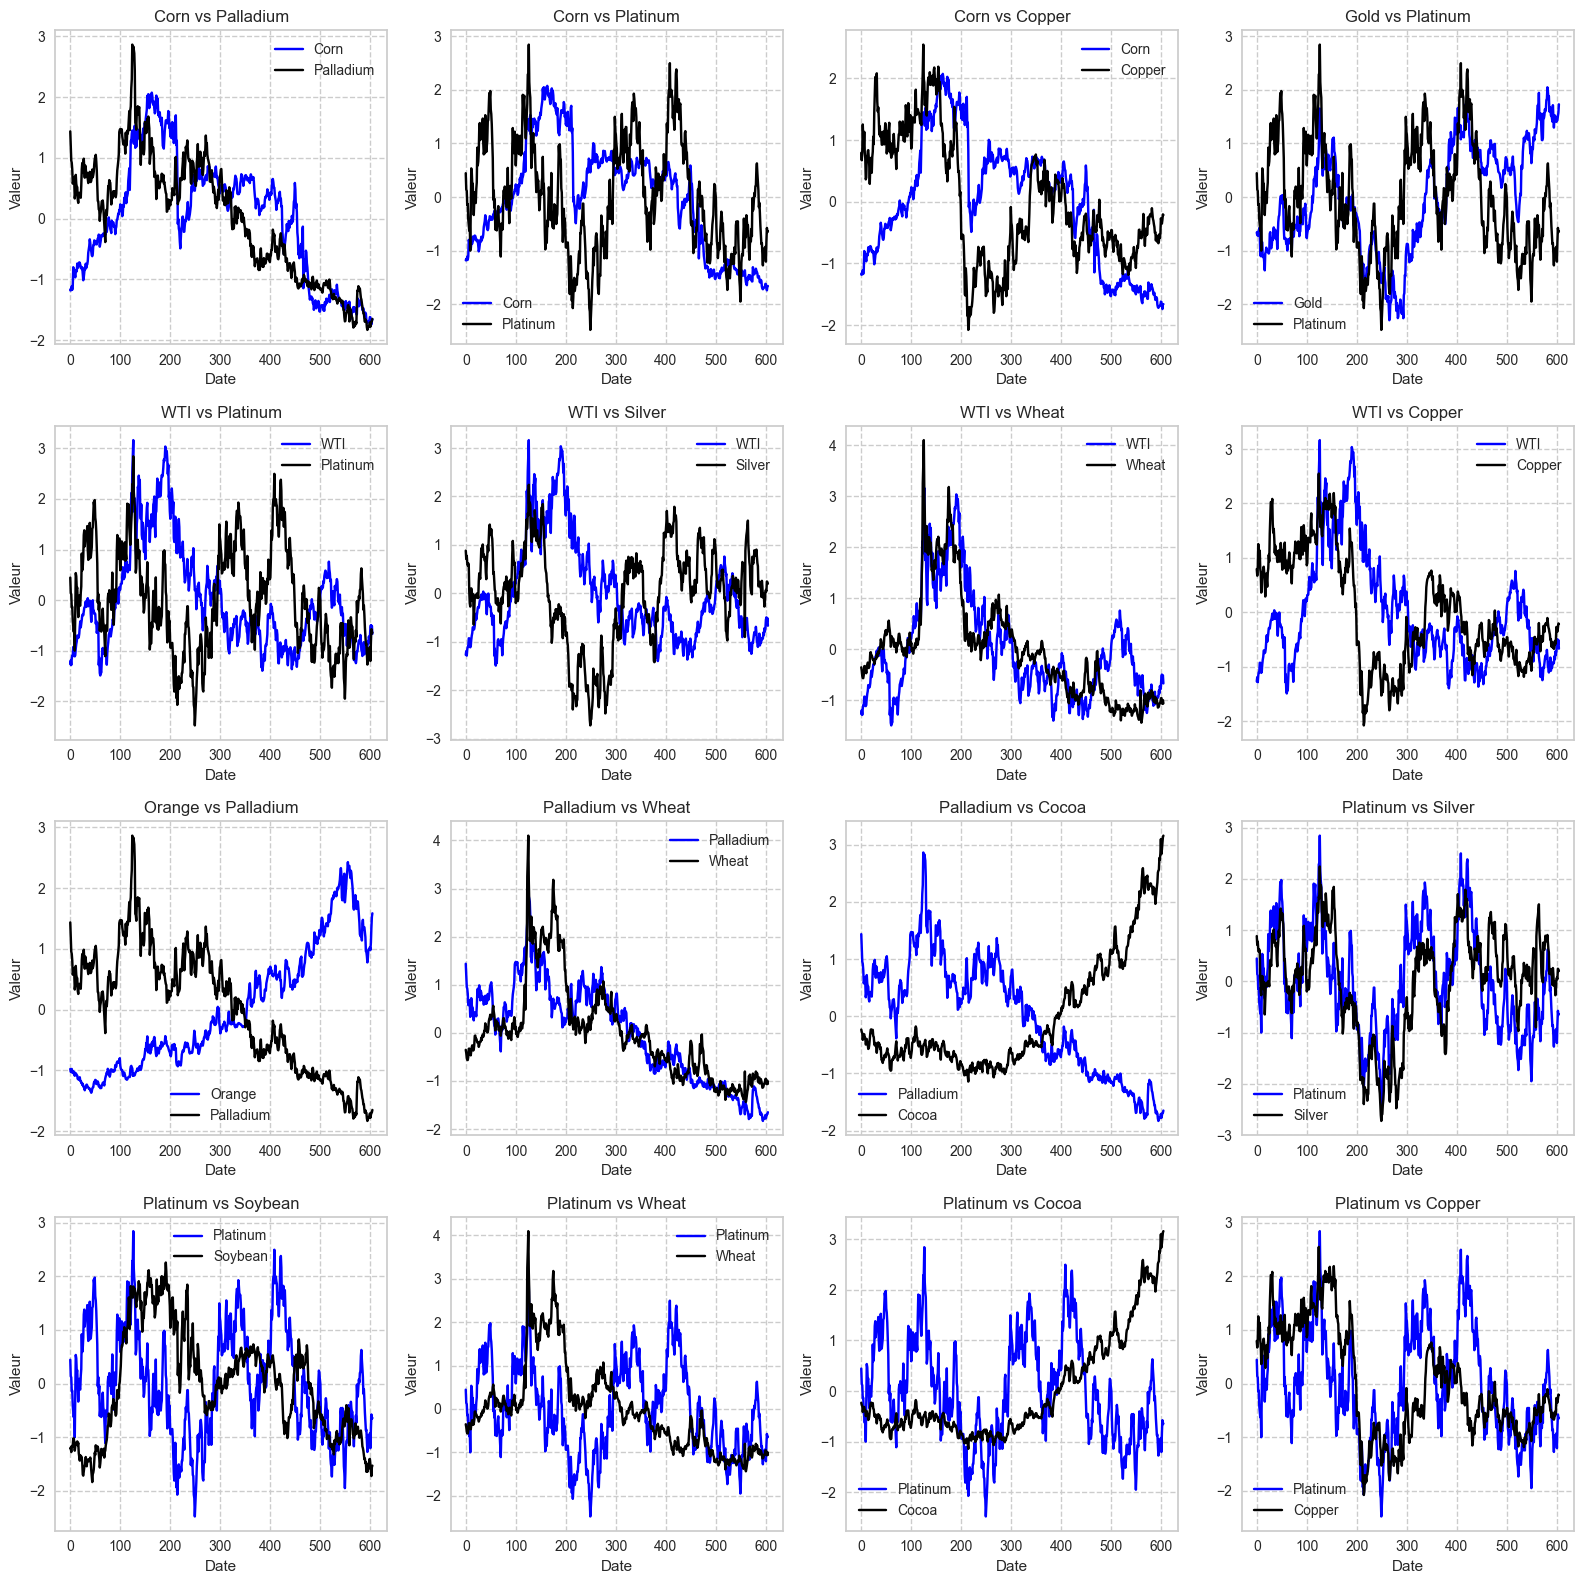

In [41]:
# Relation de cointégration : Graphique analyse

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))

for pair, ax in zip(pairs, axes.flatten()):
    variable1 = pair[0]
    variable2 = pair[1]
    ax.plot(data.index, data[variable1], label=variable1, color='blue')
    ax.plot(data.index, data[variable2], label=variable2, color='black')
    ax.set_title(f"{variable1} vs {variable2}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Valeur")
    ax.legend()
    ax.grid(True, linestyle='--')

plt.tight_layout()
plt.show()

# <u>A - VECM</u>

In [42]:
# VECM
series = data[['Platinum', 'Gold']] # On garde les variables cointégrés (voir test cointégration - Part III)

In [43]:
# Lag Section : arbitrage entre parcimonie du modèle et qualité ajustement du modèle

order_results = select_order(data=series, maxlags=25, deterministic="ci")
print(order_results.summary())

selected_aic_lag = order_results.aic
selected_bic_lag = order_results.bic
print(f"Nombre de lags optimal selon AIC: {selected_aic_lag}")
print(f"Nombre de lags optimal selon BIC: {selected_bic_lag}")

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -6.646     -6.586*    0.001299     -6.623*
1       -6.640      -6.550    0.001307      -6.605
2       -6.635      -6.515    0.001313      -6.588
3       -6.631      -6.480    0.001319      -6.572
4       -6.634      -6.453    0.001315      -6.563
5       -6.646      -6.435    0.001299      -6.564
6      -6.647*      -6.406   0.001297*      -6.553
7       -6.645      -6.374    0.001300      -6.539
8       -6.638      -6.337    0.001309      -6.521
9       -6.630      -6.299    0.001320      -6.501
10      -6.624      -6.262    0.001329      -6.483
11      -6.612      -6.220    0.001344      -6.459
12      -6.604      -6.182    0.001355      -6.440
13      -6.603      -6.151    0.001356      -6.427
14      -6.595      -6.113    0.001368      -6.407
15      -6.586      -6.074    0.001380      -6.386
16      -6.582      -6.040    0

MSE: 0.6536570574273617


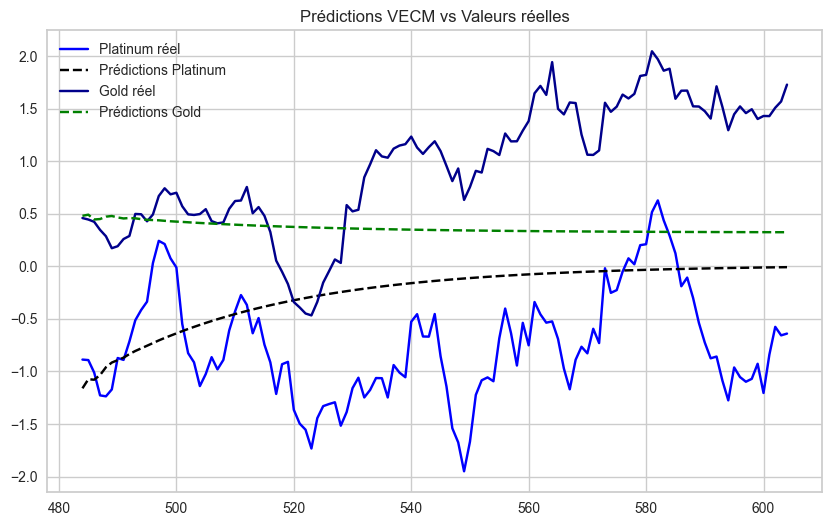

Det. terms outside the coint. relation & lagged endog. parameters for equation Platinum
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
L1.Platinum     0.0129      0.055      0.237      0.813      -0.094       0.120
L1.Gold         0.0344      0.100      0.343      0.732      -0.162       0.231
L2.Platinum     0.0043      0.054      0.078      0.938      -0.102       0.111
L2.Gold        -0.0980      0.100     -0.983      0.326      -0.293       0.097
L3.Platinum    -0.0845      0.054     -1.556      0.120      -0.191       0.022
L3.Gold         0.1773      0.100      1.778      0.075      -0.018       0.373
L4.Platinum     0.0962      0.054      1.774      0.076      -0.010       0.202
L4.Gold        -0.0323      0.100     -0.323      0.747      -0.228       0.164
L5.Platinum    -0.1262      0.054     -2.323      0.020      -0.233      -0.020
L5.Gold         0.2227      0.10

In [44]:
#'data' contient les données
series = data[['Platinum', 'Gold']]

# Division des données en ensemble d'entraînement et de test
n_obs = len(series)
train = series[:int(0.8*n_obs)]
test = series[int(0.8*n_obs):]

# Ajustement du modèle VECM
lag_order = 6
model = VECM(train, k_ar_diff=lag_order, coint_rank=1)
vecm_result = model.fit()

# Prédictions
pred = vecm_result.predict(n_obs - int(0.8*n_obs))

# Calcul du MSE
mse = mean_squared_error(test, pred)
print("MSE:", mse)

# Visualisation
color_platinum_real = '#0000ff'  # Bleu pour Platinum
color_gold_real = '#00008b'  # Bleu foncé (DarkBlue) pour Gold
color_pred_platinum = '#000000'  # Noir pour les prédictions de Platinum
color_pred_gold = '#008000'  # Vert pour les prédictions de Gold
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Platinum'], label='Platinum réel', marker='|', color=color_platinum_real)
plt.plot(test.index, pred[:, 0], label='Prédictions Platinum', linestyle='--', marker='x', color=color_pred_platinum)
plt.plot(test.index, test['Gold'], label='Gold réel', marker='|', color=color_gold_real)
plt.plot(test.index, pred[:, 1], label='Prédictions Gold', linestyle='--', marker='x', color=color_pred_gold)
plt.title('Prédictions VECM vs Valeurs réelles')
plt.legend()
plt.show()

print(vecm_result.summary())

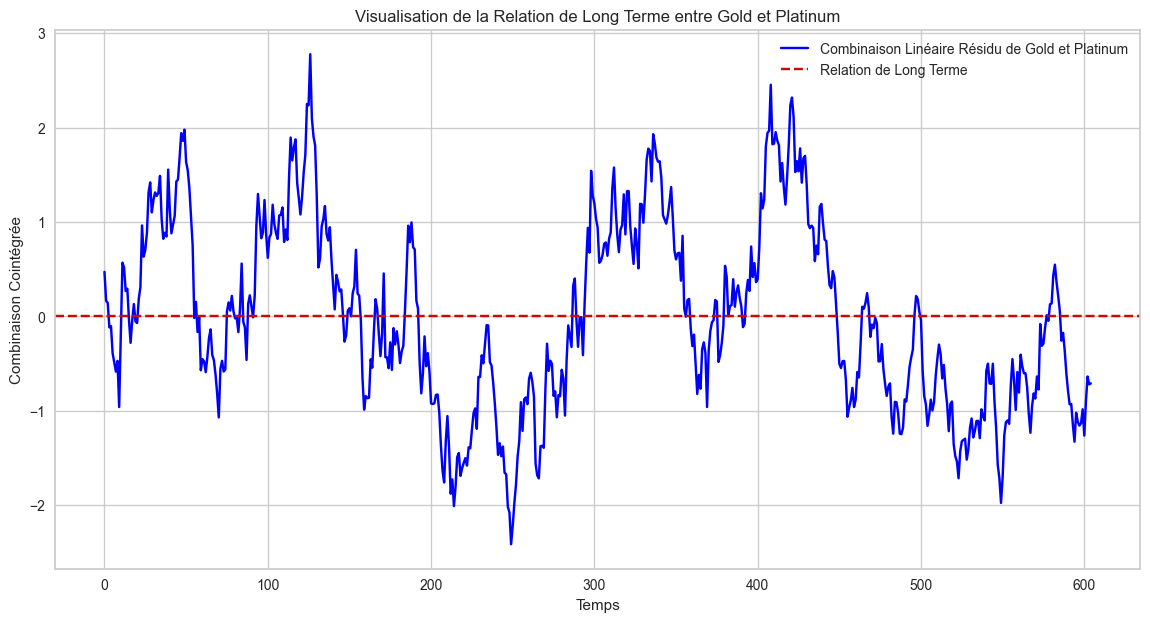

In [45]:
# Combinaison linéaire : visualisation de la relation de long terme

X = data['Platinum'].values
y = data['Gold'].values

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Prédictions à partir du modèle pour tracer la ligne de régression
predictions = model.predict(X)
beta_gold = -0.0406   #Beta 2  
beta_platinum = 1 #Beta 1 

# Calcul de la combinaison linéaire (série des résidus)
data['Cointegration_Combination'] = data['Gold']*beta_gold + data['Platinum']*beta_platinum
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Cointegration_Combination'], label='Combinaison Linéaire Résidu de Gold et Platinum', color='blue')
plt.axhline(y=0, color='r', linestyle='--', label='Relation de Long Terme')
plt.title('Visualisation de la Relation de Long Terme entre Gold et Platinum')
plt.xlabel('Temps')
plt.ylabel('Combinaison Cointégrée')
plt.legend()
plt.show()

# <u>B - Markov Switching Model</u>

In [46]:
X = data[['Gold']] # Construction d'un modèle à changement de régime
model = sm.tsa.MarkovRegression(X, k_regimes=2, trend='c', switching_variance=True)
results = model.fit()
print(results.summary()) # Résultats

                        Markov Switching Model Results                        
Dep. Variable:                   Gold   No. Observations:                  605
Model:               MarkovRegression   Log Likelihood                -480.189
Date:                Sun, 05 May 2024   AIC                            972.378
Time:                        18:45:48   BIC                            998.809
Sample:                             0   HQIC                           982.663
                                - 605                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7921      0.034    -23.293      0.000      -0.859      -0.725
sigma2         0.3448      0.028     12.449      0.0

In [47]:
predictions = results.predict()
print(predictions.head(10))

0   -0.792024
1   -0.792056
2   -0.792056
3   -0.792057
4   -0.792057
5   -0.792056
6   -0.792056
7   -0.792057
8   -0.792057
9   -0.792057
dtype: float64


In [49]:
SS_res = np.sum((X.squeeze() - predictions) ** 2)
SS_tot = np.sum((X.squeeze() - np.mean(X.squeeze())) ** 2)
r_squared = 1 - (SS_res / SS_tot)

mse = mean_squared_error(X.squeeze(), predictions)

print(f"R-squared: {r_squared}")
print(f"Mean Squared Error: {mse}")

R-squared: 0.7462204751595414
Mean Squared Error: 0.2537795248404587


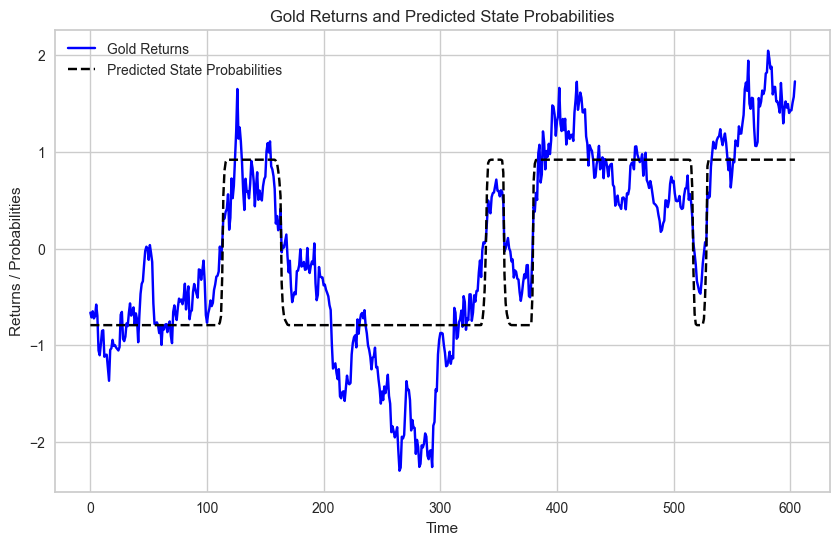

In [48]:
plt.figure(figsize=(10, 6)) 
plt.plot(X, label='Gold Returns', color='blue')
plt.plot(predictions, label='Predicted State Probabilities', color='black', alpha=1, ls ='--')
plt.title('Gold Returns and Predicted State Probabilities')
plt.xlabel('Time')
plt.ylabel('Returns / Probabilities')
plt.legend()
plt.show()